In [2]:
import pandas as pd
import time
import numpy as np
import struct
import matplotlib.pyplot as plt
from cr_data_inspection_functions import *
from lwa_antpos import mapping
from scipy.optimize import curve_fit
import scipy.stats as st
import math
from scipy import signal

Read antpos from xlsx file in repo


## Define useful function that's not already in cr_data_inspection_functions.py

In [3]:
def plot_spectra(event,antenna_names,zoom='peak',Filter='None'):
    #Event is a list of records (single-packet dictionaries) belonging to the same event
    #Antennas is a list where each element in the list is a tuple of format (s,a) where s is the index of the snap board and a is the index of the antenna to plot
    #If a requested antenna to plot is not in the list (which happens if that packet has been lost), the missing antenna is skipped
    #The requested antennas are plotted in the order they appear in event, not in the order of the input list
    #Filter can be None or a 1D numpy array of coefficients for a time-domain FIR. If filter is not 'None', the timeseries will be convolved with the provided coefficients.
    for record in event:
        s=record['board_id']
        a=record['antenna_id']
        antname=mapping.snap2_to_antpol(s,a)
        if antname in antenna_names:
            timeseries=record['data']
            if Filter!='None':
                timeseries=signal.convolve(timeseries,Filter,mode='valid')
            rms=np.std(timeseries[:2000])
            kurtosis=st.kurtosis(timeseries[:2000])
            peak=np.max(np.abs(timeseries))
            plt.figure(figsize=(20,5))
            plt.title(antname + ' snap input '+ str(s) +','+ str(a) + ' peak='+str(peak)+' rms='+str(round(rms,3))+' kurtosis='+str(round(kurtosis,3))+' peak/rms='+str(round(peak/rms,3)))
            spec = np.square(np.abs(np.fft.rfft(timeseries)))
            f = np.linspace(0, fs/2, len(spec))
            plt.plot(f, 10*np.log(spec), '.-')
            plt.xlabel("Frequency [Hz]")
            plt.ylabel("Relative Power [dB]")
           
            
    return

def plot_power_timeseries(event,antenna_names,zoom='peak',Filter1='None',Filter2='None'):
    #Plots the square of the voltage timeseries for the selected antennas, optionally filtered and smoothed
    #Event is a list of records (single-packet dictionaries) belonging to the same event
    #Antennas is a list where each element in the list is a tuple of format (s,a) where s is the index of the snap board and a is the index of the antenna to plot
    #If a requested antenna to plot is not in the list (which happens if that packet has been lost), the missing antenna is skipped
    #The requested antennas are plotted in the order they appear in event, not in the order of the input list
    #Filter1 and Filter2 each can be 'None' or a 1D numpy array of coefficients for a time-domain FIR. If filter is not 'None', the timeseries will be convolved with the provided coefficients.
    #Filter1 is applied to the raw voltage timeseries
    #Filter2 is a smoothing kernel to apply AFTER squaring the voltage timeseries to obtain a power timeseries
    for record in event:
        s=record['board_id']
        a=record['antenna_id']
        antname=mapping.snap2_to_antpol(s,a)
        if antname in antenna_names:
            timeseries=record['data']
            
            rms=np.std(timeseries[:2000])
            kurtosis=st.kurtosis(timeseries[:2000])
            peak=np.max(np.abs(timeseries))

            if Filter1!='None':
                timeseries=signal.convolve(timeseries,Filter1,mode='valid')
            timeseries=np.square(timeseries)
            if Filter2!='None':
                timeseries=signal.convolve(timeseries,Filter2,mode='valid')
            powerpeak=np.max(timeseries)
            powermean=np.mean(timeseries)

           
            plt.figure(figsize=(20,5))
            plt.suptitle(antname + ' snap input '+ str(s) +','+ str(a) + ' peak='+str(peak)+' rms='+str(round(rms,3))+' kurtosis='+str(round(kurtosis,3))+' peak/rms='+str(round(peak/rms,3))+'power peak'+str(round(powerpeak,3)) +'power mean'+str(round(powerpeak,3)) +'snr'+str(round(powerpeak/powermean,3)))
            
            plt.subplot(121)
            plt.plot(timeseries)
            plt.xlabel('time sample')
            plt.ylabel('voltage [ADC units]')

            plt.subplot(122)
            plt.plot(timeseries)
            plt.xlabel('time sample')
            plt.ylabel('voltage [ADC units]')
            if zoom=='peak':
                plt.xlim(np.argmax(timeseries)-50,np.argmax(timeseries)+150)
            else:
                plt.xlim(zoom[0],zoom[1])
    return

## Set Sample Rate

In [4]:
fs=196.30822126189432 #MHz
ts=1e9/(fs*1e6) #ns

## Examine Filter

In [5]:
#coefficients copied from Matlab FDA tool

#6th order
h= np.asarray([0.147691289136769848822083872619259636849,
                   -0.323933490249486866208172841652412898839,
                   -0.232672603812139389134472367004491388798,
                    0.453321166545050502350022725295275449753,
                   -0.232672603812139389134472367004491388798,
                   -0.323933490249486866208172841652412898839,
                   0.147691289136769848822083872619259636849])

#24th order
h= np.asarray([0.000049291111379545783611425685544205066,
               0.012255497574972781804625299173494568095,
               0.085289616177628382875930412865272955969,
               -0.063136263203890236050952466939634177834,
               -0.021489412960359111082198069198057055473,
               -0.067555957743183181474222465112688951194,
               -0.017706118779731286339007567676162580028,
               0.080882151494431037130894424080906901509,
               -0.014358148251631907416081546102759602945,
               0.093835202832724035060252276707615237683,
               -0.280577771800571862392814637132687494159,
               -0.129748808680352711864003367736586369574,
               0.501393724111570460166831253445707261562,
               -0.129748808680352711864003367736586369574,
               -0.280577771800571862392814637132687494159,
               0.093835202832724035060252276707615237683,
               -0.014358148251631907416081546102759602945,
               0.080882151494431037130894424080906901509,
               -0.017706118779731286339007567676162580028,
               -0.067555957743183181474222465112688951194,
               -0.021489412960359111082198069198057055473,
               -0.063136263203890236050952466939634177834,
               0.085289616177628382875930412865272955969,
               0.012255497574972781804625299173494568095,
               0.000049291111379545783611425685544205066])

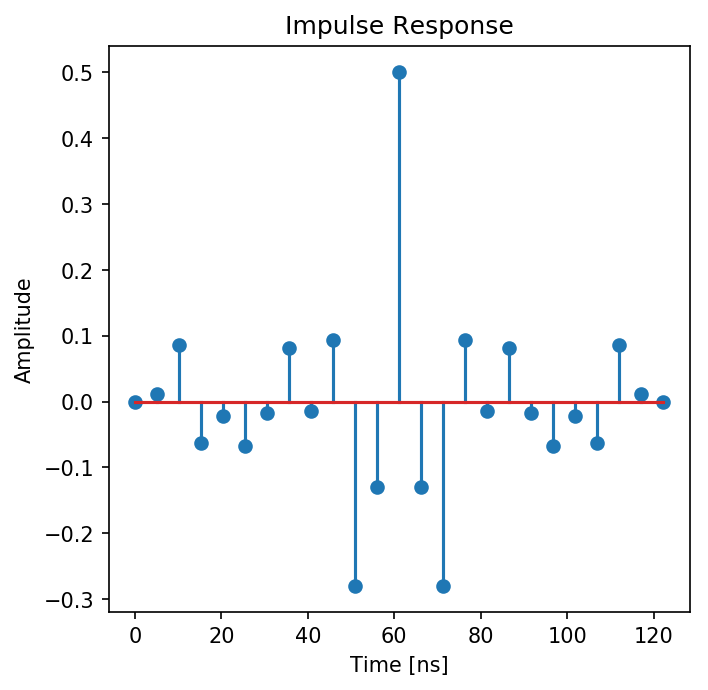

In [6]:
plt.figure(figsize=(5,5),dpi=150)
plt.stem(ts*np.asarray(range(len(h))),h)
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude")
plt.title("Impulse Response")
plt.show()

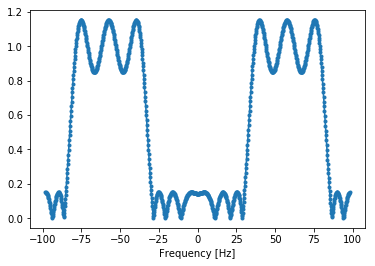

In [7]:
# plot the frequency response -- taken from the pydsr tutorial https://pysdr.org/content/filters.html
H = np.abs(np.fft.fft(h, 1024)) # take the 1024-point FFT and magnitude
H = np.fft.fftshift(H) # make 0 Hz in the center
w = np.linspace(-fs/2, fs/2, len(H)) # x axis
plt.figure('freq')
plt.plot(w, H, '.-')
plt.xlabel('Frequency [Hz]')
plt.show()

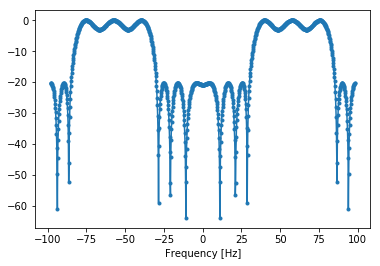

In [8]:
# plot the frequency response -- now in dB
H = np.abs(np.fft.fft(h, 1024)) # take the 1024-point FFT and magnitude
H = np.fft.fftshift(H) # make 0 Hz in the center
w = np.linspace(-fs/2, fs/2, len(H)) # x axis
plt.plot(w, 10*np.log(H/np.max(H)), '.-')
plt.xlabel('Frequency [Hz]')

plt.show()

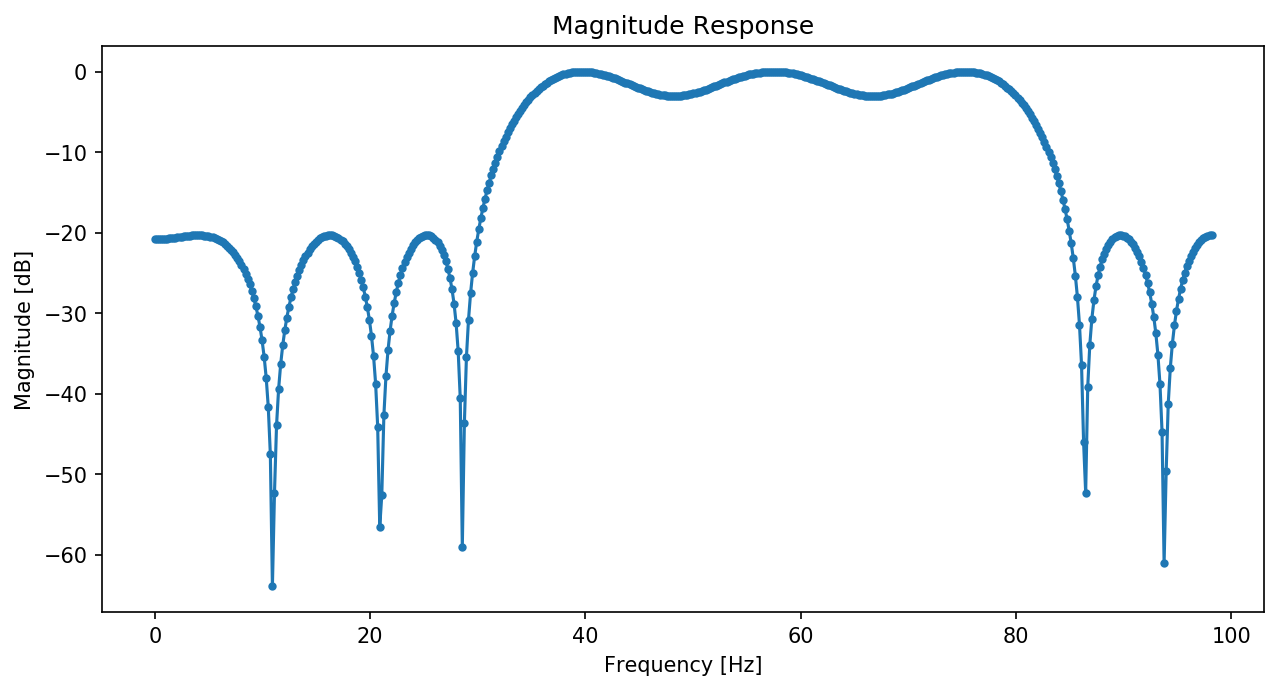

In [9]:
# plot the frequency response in dB, just the real frequencies
plt.figure(figsize=(10,5),dpi=150)

H = np.abs(np.fft.rfft(h, 1024)) # take the 1024-point FFT and magnitude
w = np.linspace(0, fs/2, len(H)) # x axis
plt.plot(w, 10*np.log(H/np.max(H)), '.-')
plt.title('Magnitude Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.show()

# Apply filter to example signals
## 1. Simulated White Noise

In [10]:
record_length=4096
rms1=30
simulated_white_noise=30*np.random.randn(record_length)
filtered=signal.convolve(h,simulated_white_noise)
print(filtered.shape)


(4120,)


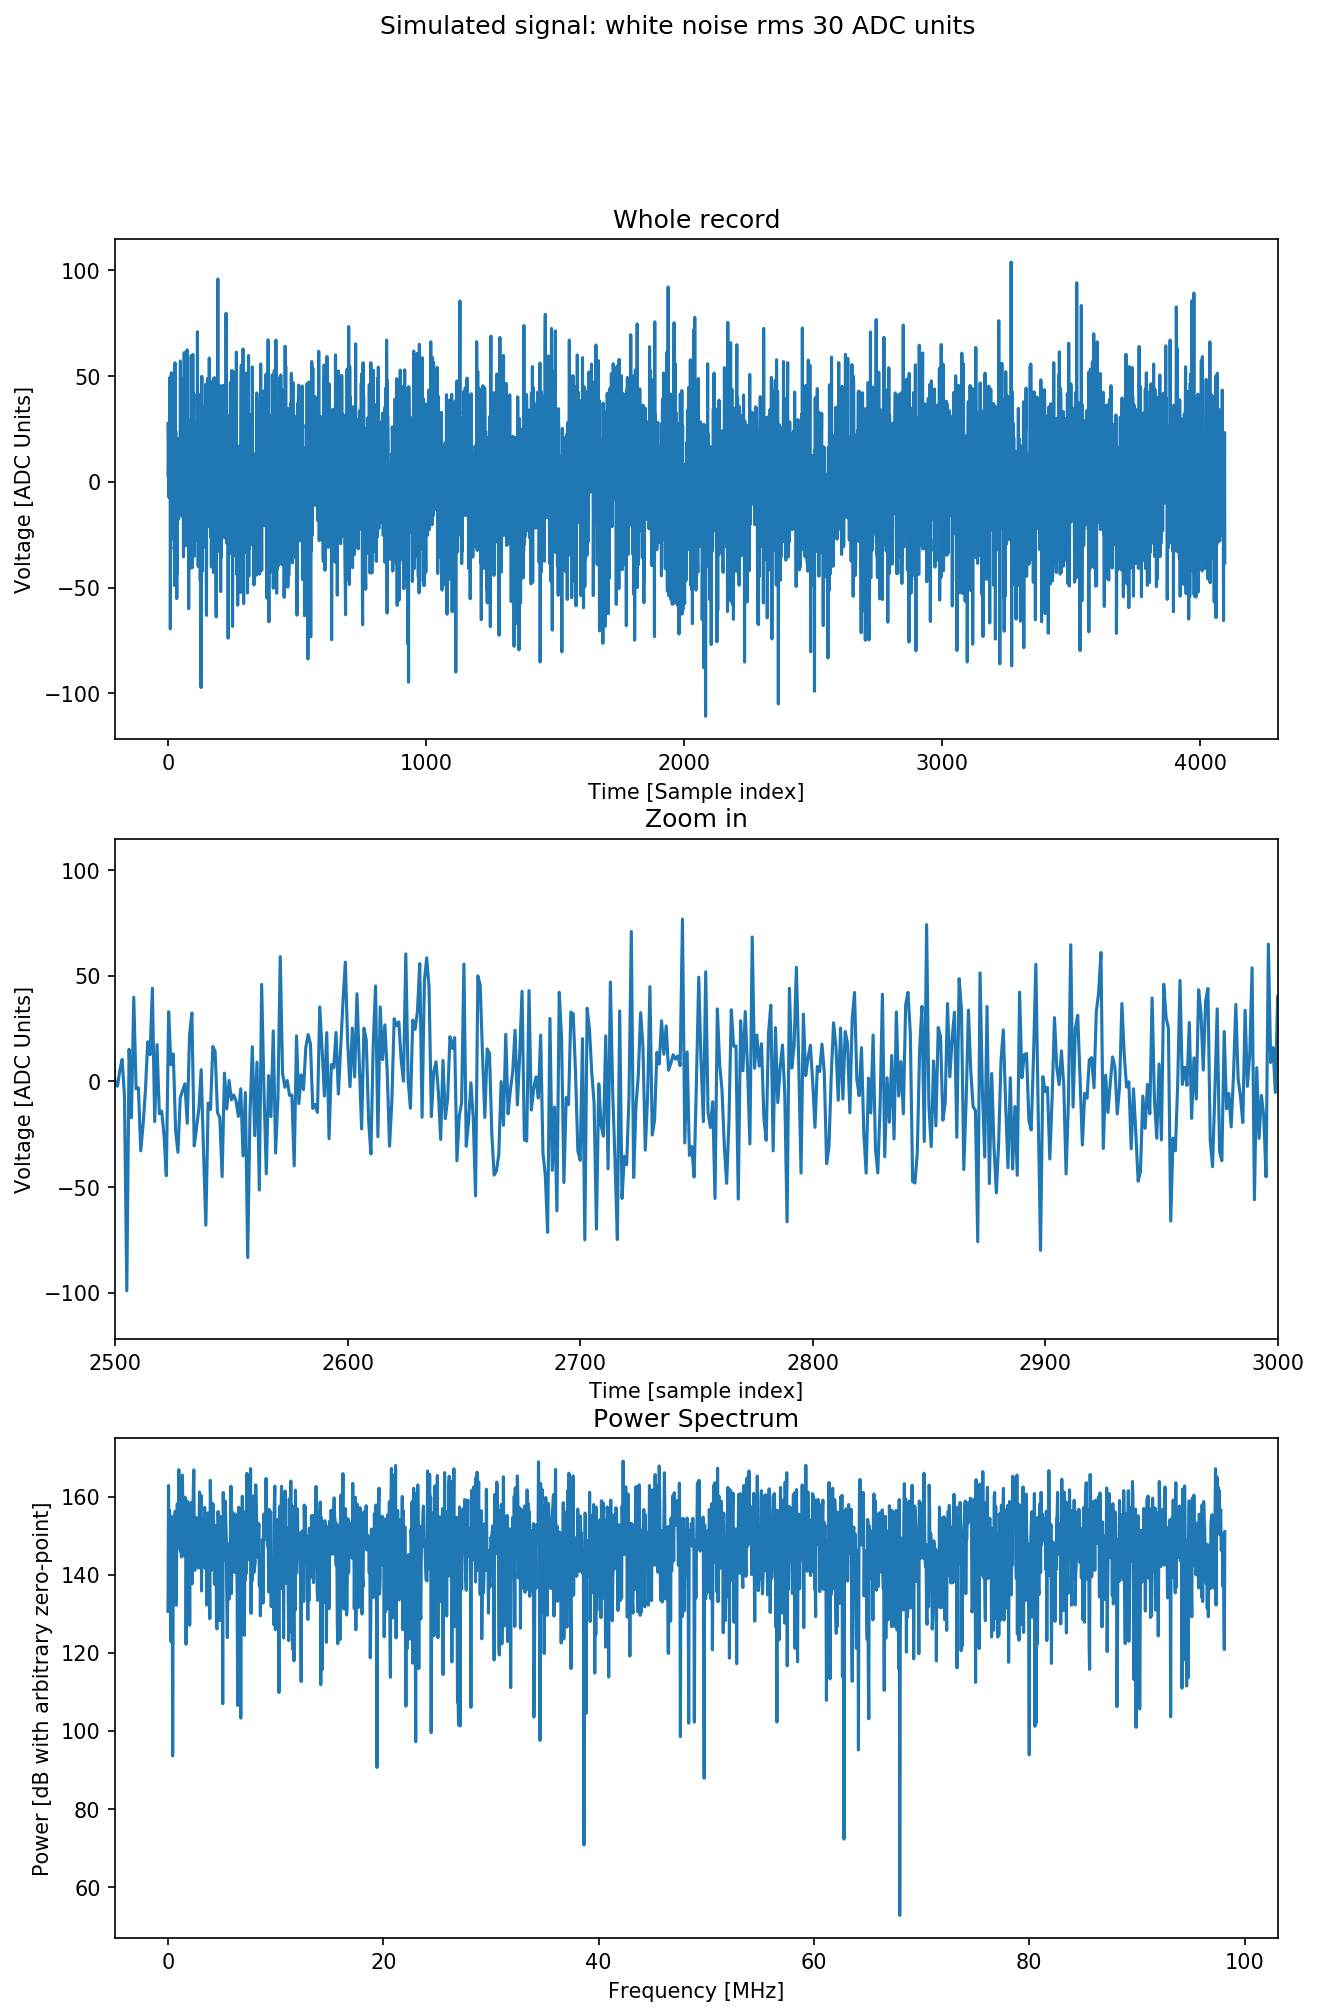

In [11]:
plt.figure(figsize=(10,15),dpi=150)
plt.suptitle("Simulated signal: white noise rms 30 ADC units")

plt.subplot(311)
plt.plot(simulated_white_noise)
plt.xlabel('Time [Sample index]')
plt.ylabel('Voltage [ADC Units]')
plt.title('Whole record')

plt.subplot(312)
plt.plot(simulated_white_noise)
plt.xlim(2500,3000)
plt.title('Zoom in')
plt.ylabel('Voltage [ADC Units]')
plt.xlabel('Time [sample index]')

plt.subplot(313)
spectrum = np.square(np.abs(np.fft.rfft(simulated_white_noise))) # take the 1024-point FFT and magnitude
f = np.linspace(0, fs/2, len(spectrum)) # x axis
plt.plot(f, 10*np.log(spectrum)) #in dB but not normalized
plt.title('Power Spectrum')
plt.ylabel('Power [dB with arbitrary zero-point]')
plt.xlabel('Frequency [MHz]')

plt.show()

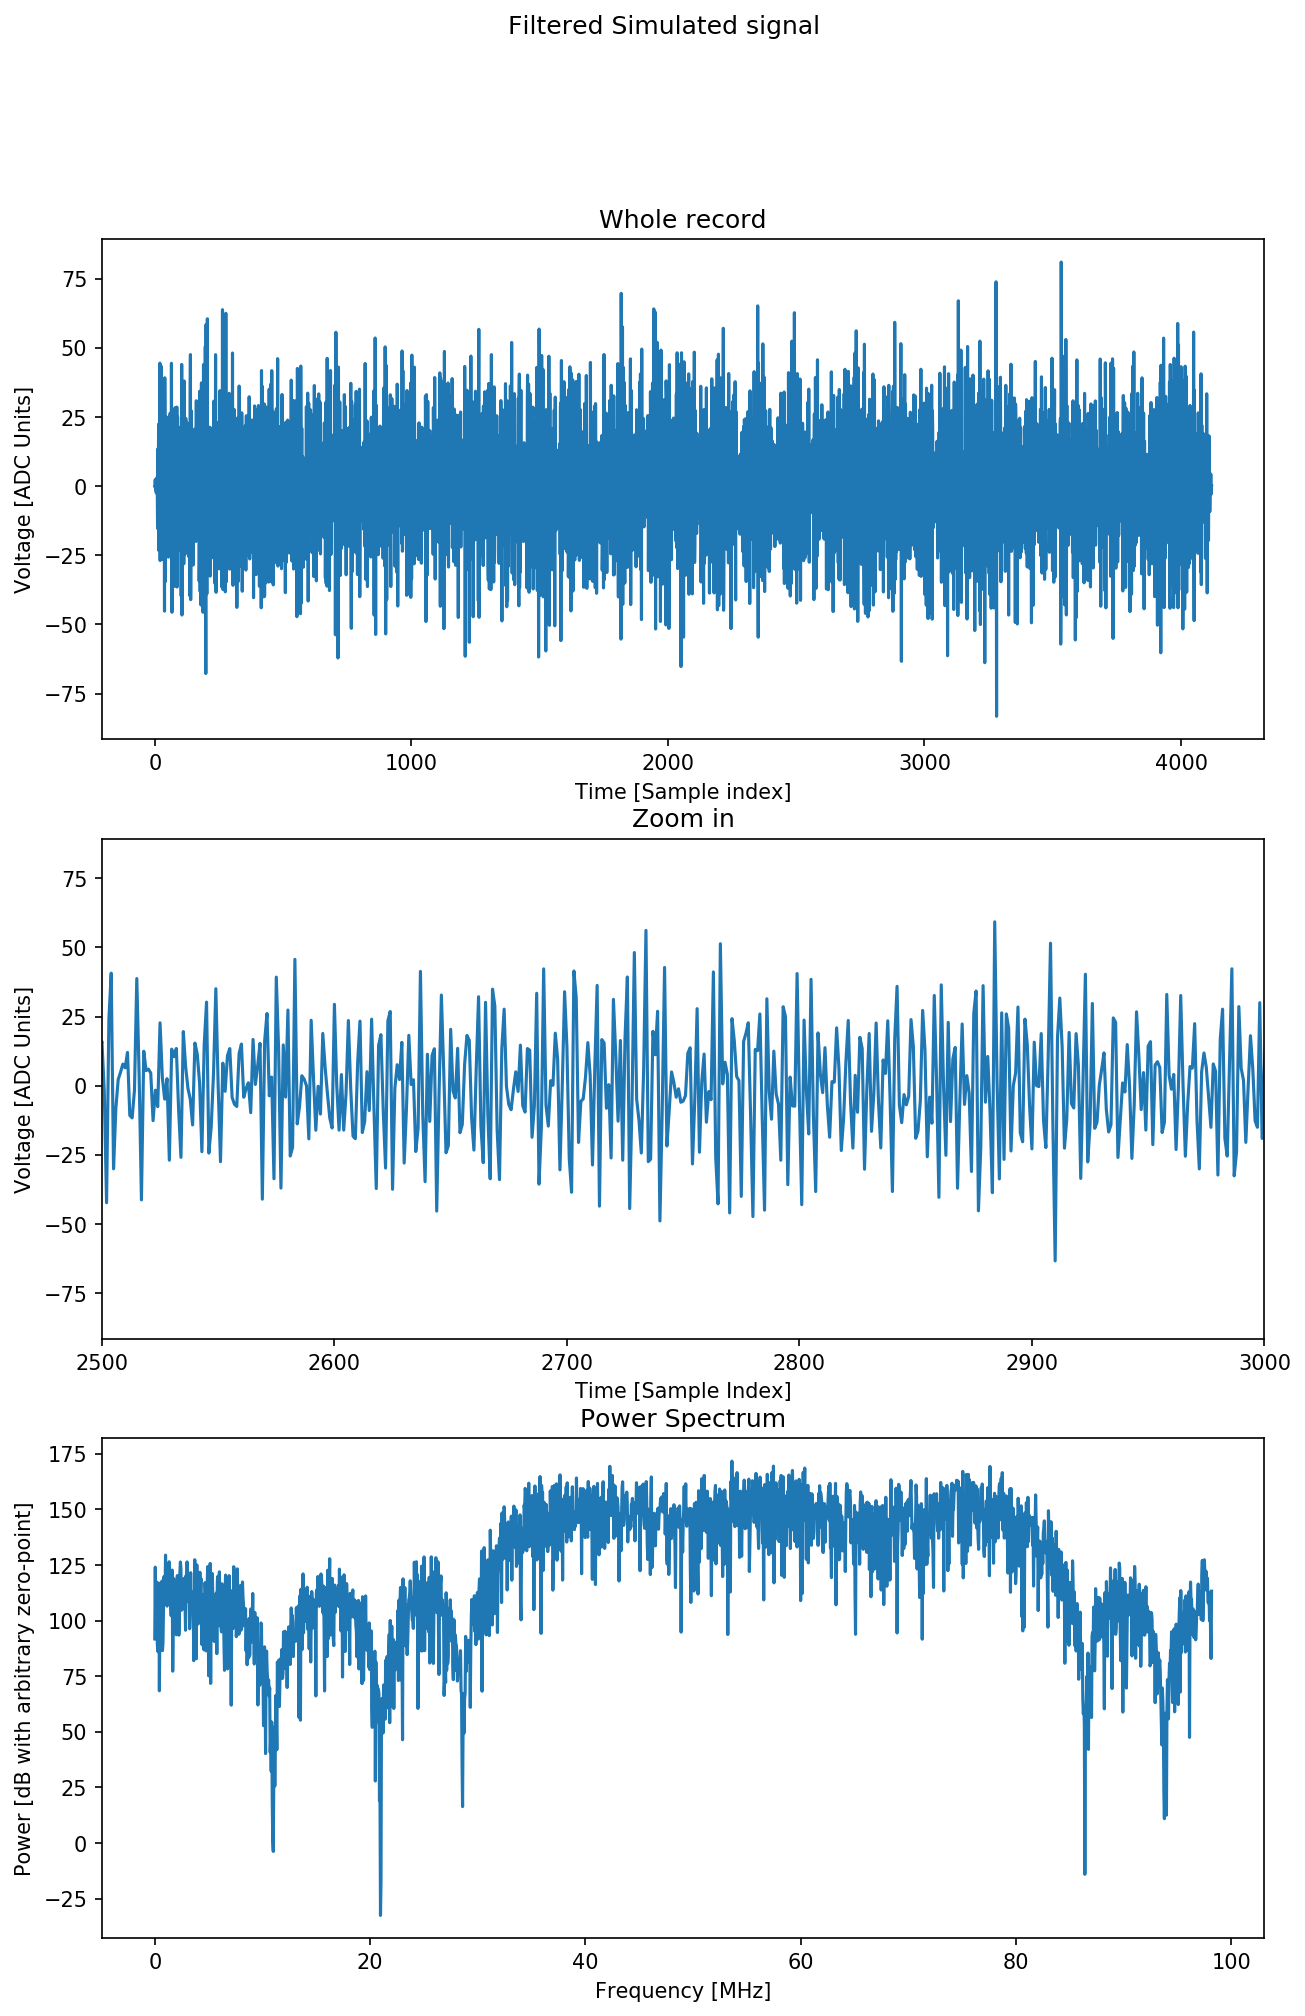

In [12]:
plt.figure(figsize=(10,15),dpi=150)
plt.suptitle("Filtered Simulated signal")

plt.subplot(311)
plt.plot(filtered)
plt.xlabel('Time [Sample index]')
plt.ylabel('Voltage [ADC Units]')
plt.title('Whole record')

plt.subplot(312)
plt.plot(filtered)
plt.xlim(2500,3000)
plt.title('Zoom in')
plt.ylabel('Voltage [ADC Units]')
plt.xlabel('Time [Sample Index]')


plt.subplot(313)
spectrum = np.square(np.abs(np.fft.rfft(filtered))) # take the 1024-point FFT and magnitude
f = np.linspace(0, fs/2, len(spectrum)) # x axis
plt.plot(f, 10*np.log(spectrum)) #in dB but not normalized
plt.title('Power Spectrum')
plt.ylabel('Power [dB with arbitrary zero-point]')
plt.xlabel('Frequency [MHz]')

plt.show()

In [13]:
print("Expected RMS of simulated signal: ",rms1)
print("Actual RMS of simulated signal: ",np.std(simulated_white_noise))
print("RMS of filtered signal: ",np.std(filtered))

Expected RMS of simulated signal:  30
Actual RMS of simulated signal:  29.80979315035464
RMS of filtered signal:  21.228513125575788


In [14]:
print(np.mean(simulated_white_noise),np.mean(filtered))

-0.16730768540682223 0.02380687420503196


## Simulated White Noise Plus a delta function

In [15]:
record_length=4096
rms1=30
simulated_record=30*np.random.randn(record_length)
simulated_record[2700]=200+simulated_record[2700]
filtered=signal.convolve(h,simulated_record)
print(filtered.shape)


(4120,)


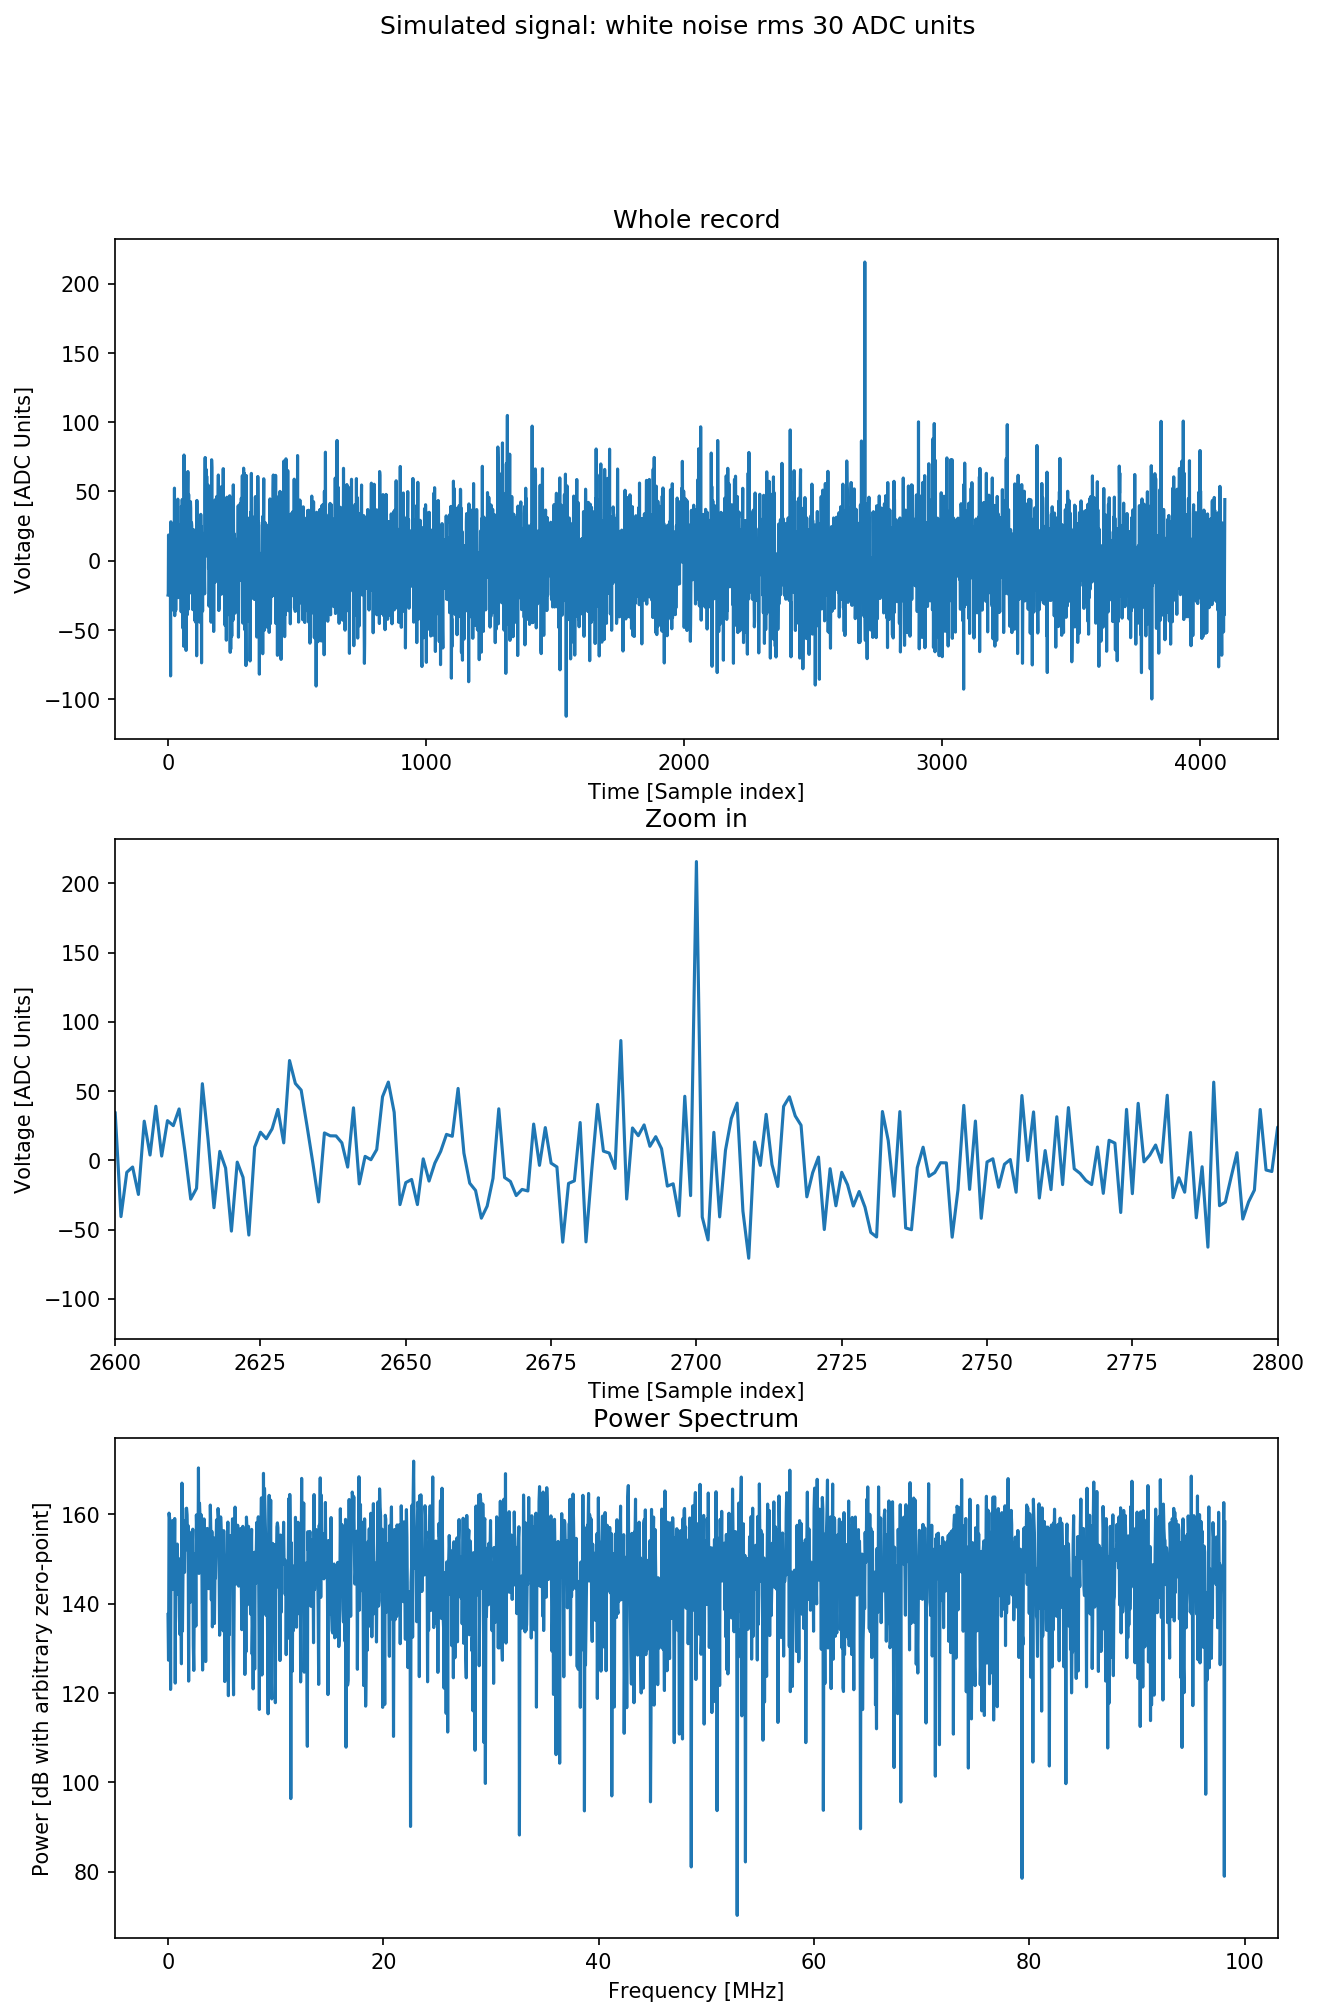

In [16]:
plt.figure(figsize=(10,15),dpi=150)
plt.suptitle("Simulated signal: white noise rms 30 ADC units")

plt.subplot(311)
plt.plot(simulated_record)
plt.xlabel('Time [Sample index]')
plt.ylabel('Voltage [ADC Units]')
plt.title('Whole record')

plt.subplot(312)
plt.plot(simulated_record)
plt.xlim(2600,2800)
plt.title('Zoom in')
plt.ylabel('Voltage [ADC Units]')
plt.xlabel('Time [Sample index]')

plt.subplot(313)
spectrum = np.square(np.abs(np.fft.rfft(simulated_record))) # take the 1024-point FFT and magnitude
f = np.linspace(0, fs/2, len(spectrum)) # x axis
plt.plot(f, 10*np.log(spectrum)) #in dB but not normalized
plt.title('Power Spectrum')
plt.ylabel('Power [dB with arbitrary zero-point]')
plt.xlabel('Frequency [MHz]')

plt.show()

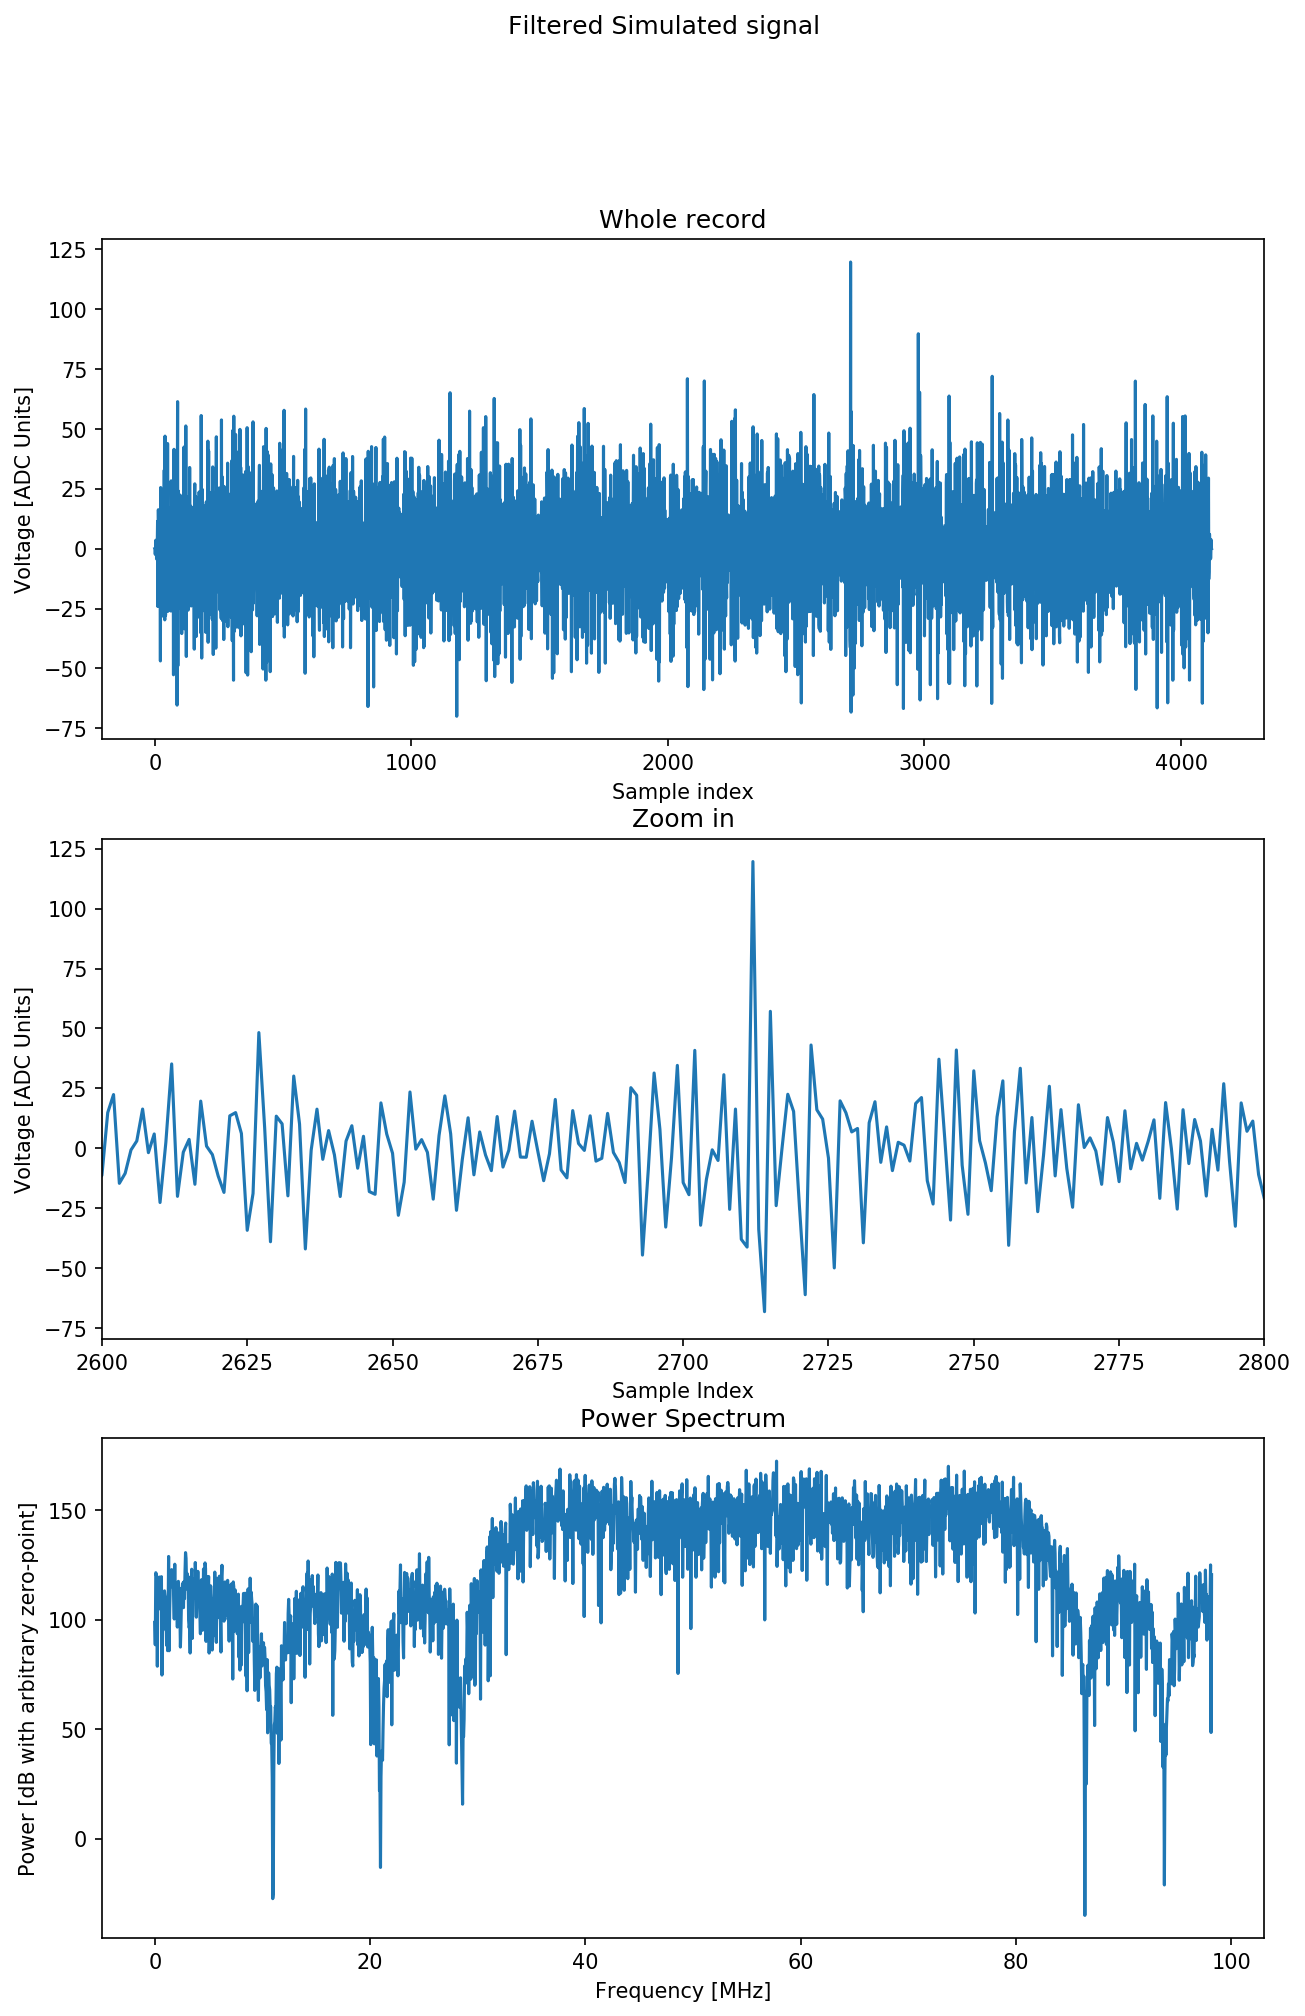

In [17]:
plt.figure(figsize=(10,15),dpi=150)
plt.suptitle("Filtered Simulated signal")

plt.subplot(311)
plt.plot(filtered)
plt.xlabel('Sample index')
plt.ylabel('Voltage [ADC Units]')
plt.title('Whole record')

plt.subplot(312)
plt.plot(filtered)
plt.xlim(2600,2800)
plt.title('Zoom in')
plt.ylabel('Voltage [ADC Units]')
plt.xlabel('Sample Index')


plt.subplot(313)
spectrum = np.square(np.abs(np.fft.rfft(filtered))) # take the 1024-point FFT and magnitude
f = np.linspace(0, fs/2, len(spectrum)) # x axis
plt.plot(f, 10*np.log(spectrum)) #in dB but not normalized
plt.title('Power Spectrum')
plt.ylabel('Power [dB with arbitrary zero-point]')
plt.xlabel('Frequency [MHz]')

plt.show()

## Simulation to figure out what power change ratio cut should be

In [22]:
record_length=4096
rms1=30
sm=(1/4)*np.ones(4)
ntrials=10000
changeratios=np.zeros(ntrials)

for i in range(ntrials):
    simulated_record=rms1*np.random.randn(record_length)
    simulated_record[2700]=200+simulated_record[2700]
    filtered=signal.convolve(simulated_record,h,mode='valid')
    powertimeseries=np.square(filtered)
    smoothed=signal.convolve(powertimeseries,sm,mode='valid')
    before=np.mean(smoothed[:2000])
    tpeak=np.argmax(smoothed)
    if tpeak<(len(smoothed)-60):
        after=np.mean(smoothed[tpeak+10:tpeak+60])
    else:
        after=0
    ratio=after/before
    changeratios[i]=ratio


0.6400000000000001 1.44
0.9813
0.8526
0.9662


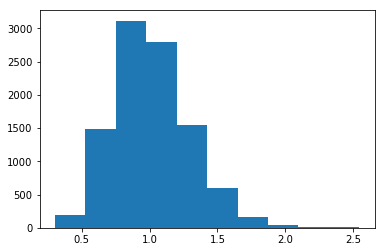

In [31]:
plt.hist(changeratios[changeratios>0])
print(0.8**2,1.2**2)
print(np.sum(np.logical_and(0.5<changeratios,changeratios<2))/ntrials)
print(np.sum(np.logical_and(0.8**2<changeratios,changeratios<1.2**2))/ntrials)
print(np.sum(np.logical_and(0.5<changeratios,changeratios<1.7))/ntrials)

# Apply filter to real events

In [76]:
datadir='/data0/cosmic-ray-data/2023May3/data-to-save/'
dataproductsdir='/data0/cosmic-ray-data/2023May3-dataproducts/'

summary_filename='/data0/cosmic-ray-data/2023May3-dataproducts/summary.txt'

colnames=['fname',
          'total_event_count',
          'complete_events_count',
          'incomplete_events_count',
          'scrambled_complete_events',
          'pass_rms_change_cut',
          'pass_veto_cut',
          'pass_max_distant_vs_core_cut',
          'pass_top5_distant_vs_core_cut',
          'pass_distant_vs_core_cut2',
          'total_selected_v1',
          'total_selected_v2']

#parse summary file into dictionary
with open(summary_filename) as file:
    lines = [line.rstrip().split() for line in file if line[:2]=='ov']
    
summary = pd.DataFrame(columns=colnames,index=range(len(lines)))

for j,line in enumerate(lines):
    for i in range(len(line)):
        if i: #skip the first one
            line[i]=int(line[i])
    summary.loc[j]=line
    
##load arraymap
array_map=pd.read_csv('array-map-5-22-2023.csv')
xdict={}
ydict={}
zdict={}
for i,n in enumerate(array_map['antname']):
    xdict[n]=array_map['x'][i]
    ydict[n]=array_map['y'][i]
    zdict[n]=array_map['elevation'][i]
arraymapdictionaries=[xdict,ydict,zdict]

In [77]:
files_with_interesting_events=[]
for i in range(len(summary)):
    if (summary['total_selected_v1'][i]):
        #print(summary['fname'][i],summary['total_selected_v1'][i])
        files_with_interesting_events.append(summary['fname'][i])






In [78]:
## Plot the first 10 events to give some examples to choose from
'''
for datafname in files_with_interesting_events[:10]:
    saved_events_indices=np.load(dataproductsdir+datafname[:-3]+'indices_cuts1.npy')
    for i in saved_events_indices:
        event_records=parsefile(datadir+datafname,start_ind=i,end_ind=704 )
        merged=mergepolarizations(event_records,arraymapdictionaries)
        print(datafname, i)
        plot_event_peak_to_rms(event_records,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)
        plot_event_toas(event_records,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)

        coreA,coreB,farA,farB=rank_by_snr(event_records,arraymapdictionaries)
        for rankedlist in coreA,coreB,farA,farB:
            if len(rankedlist)>1:
                plot_timeseries(event_records,[A[1] for A in rankedlist[:1]],zoom='peak')
            else:
                plot_timeseries(event_records,[A[1] for A in rankedlist],zoom='peak')

    plt.show()'''

"\nfor datafname in files_with_interesting_events[:10]:\n    saved_events_indices=np.load(dataproductsdir+datafname[:-3]+'indices_cuts1.npy')\n    for i in saved_events_indices:\n        event_records=parsefile(datadir+datafname,start_ind=i,end_ind=704 )\n        merged=mergepolarizations(event_records,arraymapdictionaries)\n        print(datafname, i)\n        plot_event_peak_to_rms(event_records,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)\n        plot_event_toas(event_records,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)\n\n        coreA,coreB,farA,farB=rank_by_snr(event_records,arraymapdictionaries)\n        for rankedlist in coreA,coreB,farA,farB:\n            if len(rankedlist)>1:\n                plot_timeseries(event_records,[A[1] for A in rankedlist[:1]],zoom='peak')\n            else:\n                plot_timeseries(event_records,[


### Plots for one event, First without the filter, then with the filter


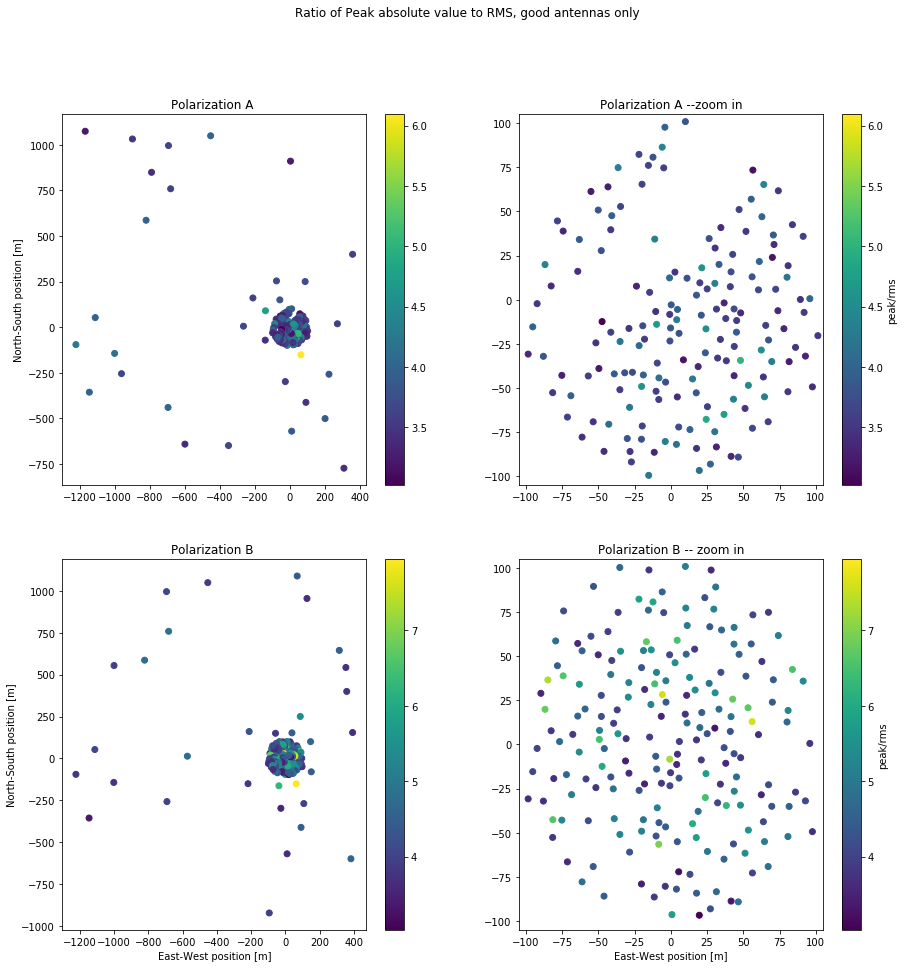

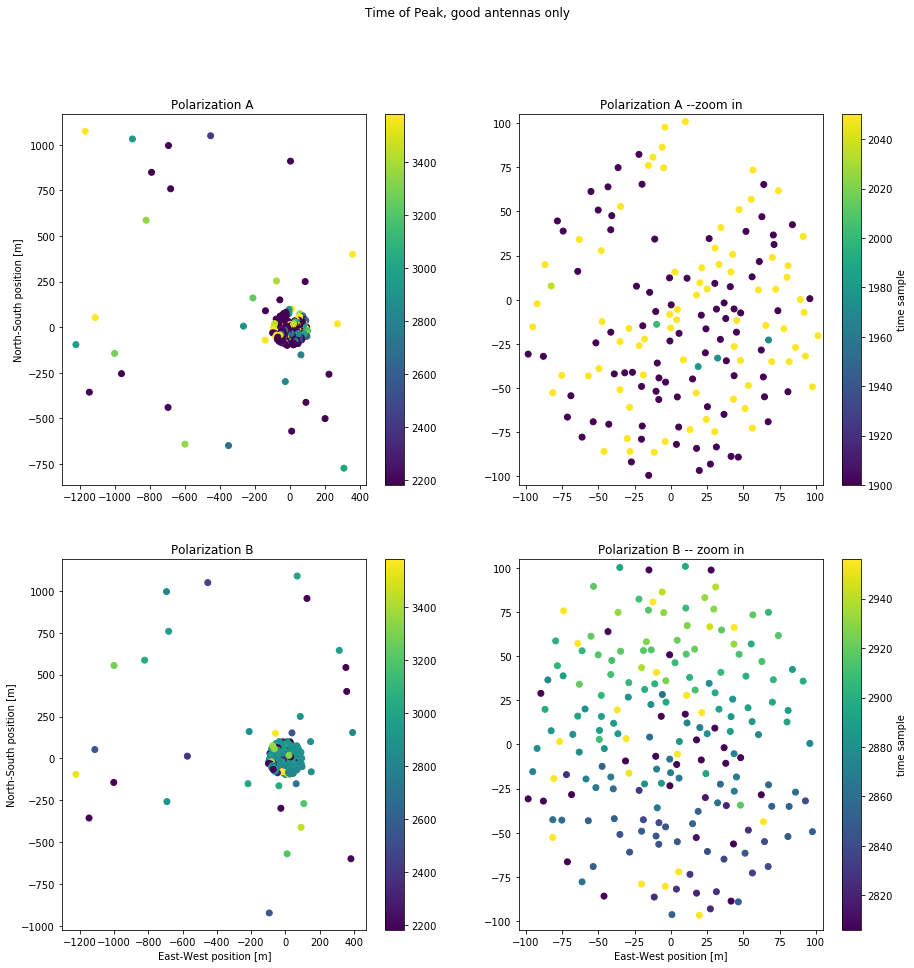

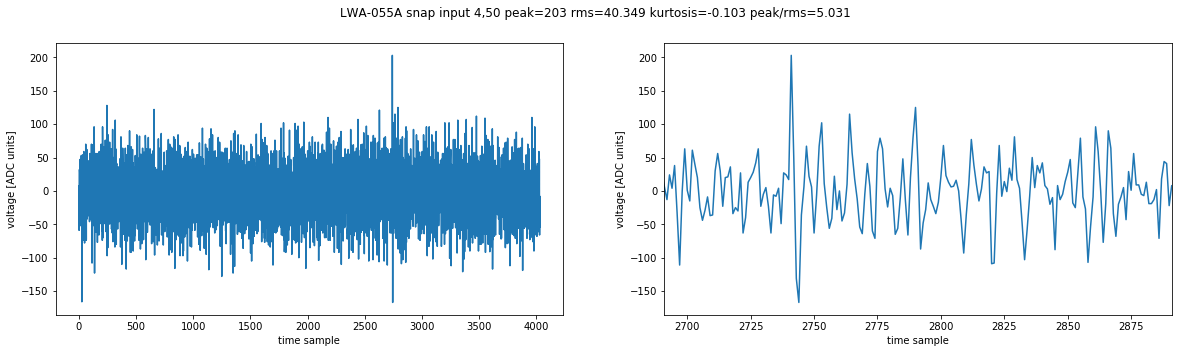

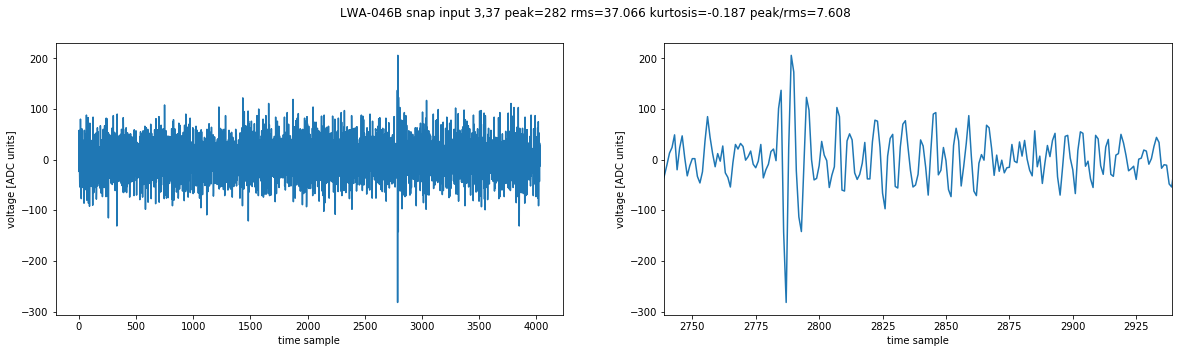

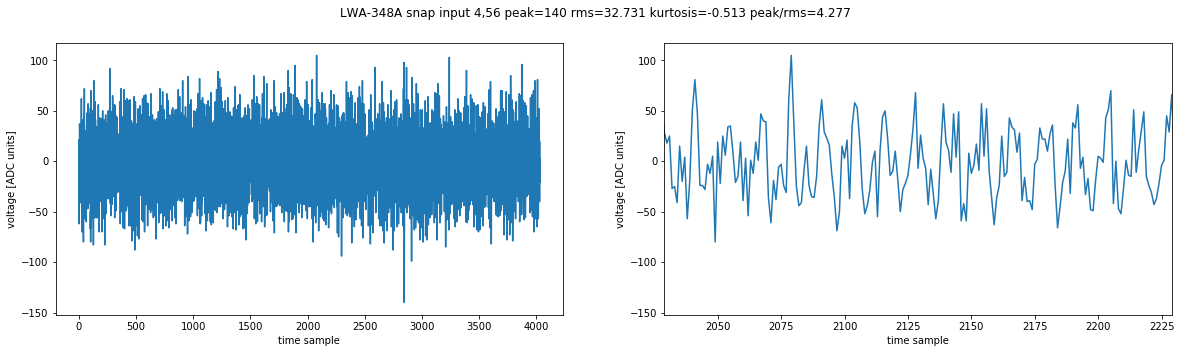

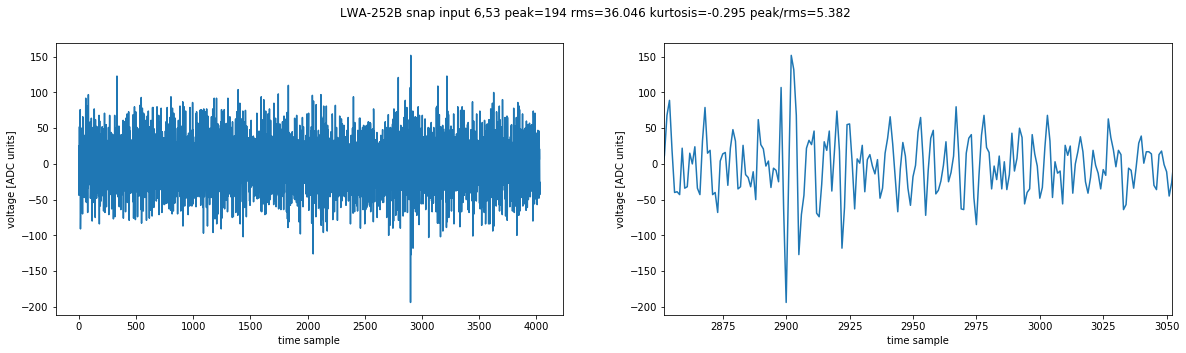

In [79]:
#load the desired event

datafname =files_with_interesting_events[1]
saved_events_indices=np.load(dataproductsdir+datafname[:-3]+'indices_cuts1.npy')
i=saved_events_indices[0]
event_records=parsefile(datadir+datafname,start_ind=i,end_ind=704 )

#without the filter
merged=mergepolarizations(event_records,arraymapdictionaries)
rmsA=np.asarray([record['rmsA'] for record in merged])
peakA=np.asarray([record['peakA'] for record in merged])
rmsB=np.asarray([record['rmsB'] for record in merged])
peakB=np.asarray([record['peakB'] for record in merged])
peak_to_rmsA=peakA/rmsA
peak_to_rmsB=peakB/rmsB
kurtosisA=np.asarray([record['kurtosisA'] for record in merged])
kurtosisB=np.asarray([record['kurtosisB'] for record in merged])
    
plot_event_peak_to_rms(event_records,arraymapdictionaries,minimum_ok_rms=20,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)
plot_event_toas(event_records,arraymapdictionaries,minimum_ok_rms=20,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)

coreA,coreB,farA,farB=rank_by_snr(event_records,arraymapdictionaries,minimum_ok_rms=20,maximum_ok_rms=45)
for rankedlist in coreA,coreB,farA,farB:
    if len(rankedlist)>1:
        plot_timeseries(event_records,[A[1] for A in rankedlist[:1]],zoom='peak')
    else:
        plot_timeseries(event_records,[A[1] for A in rankedlist],zoom='peak')



/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':
/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:218: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':
/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':


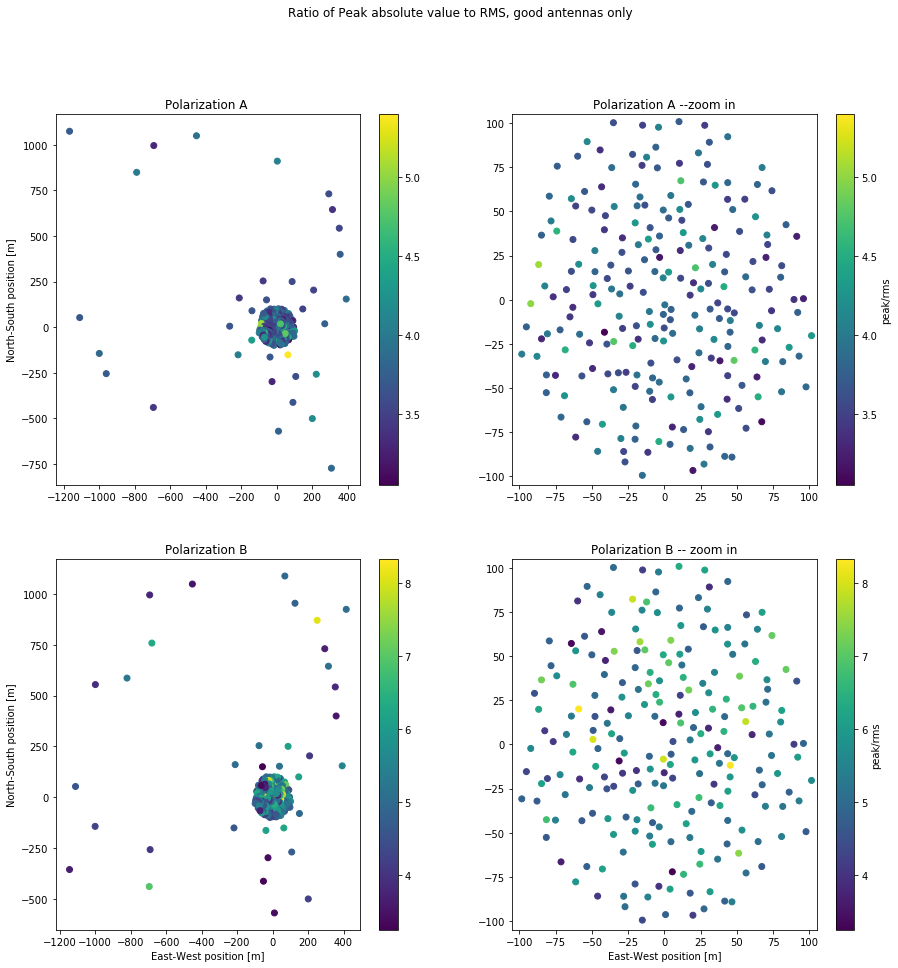

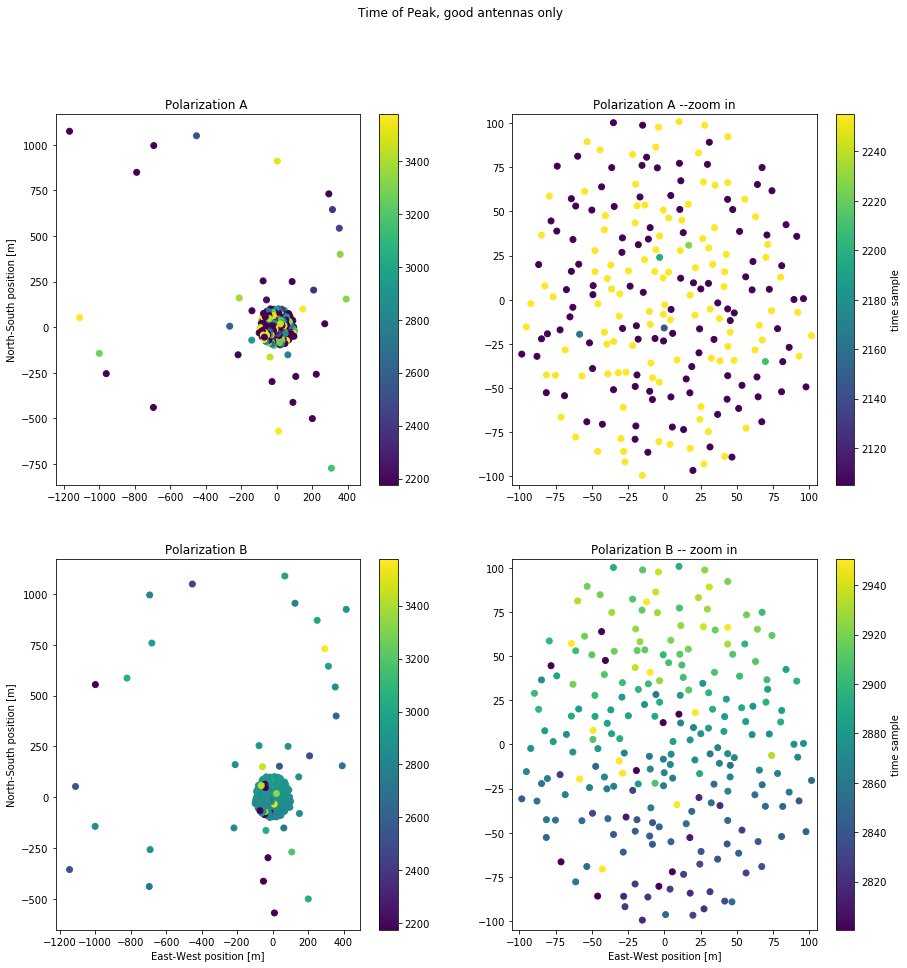

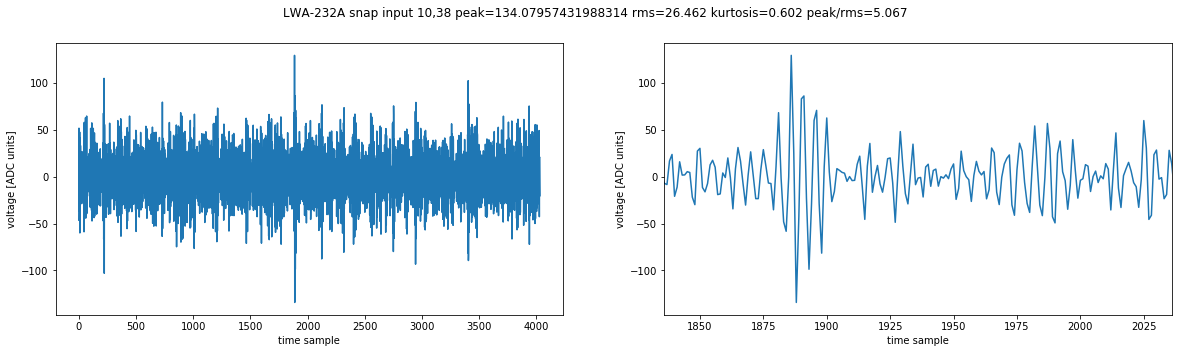

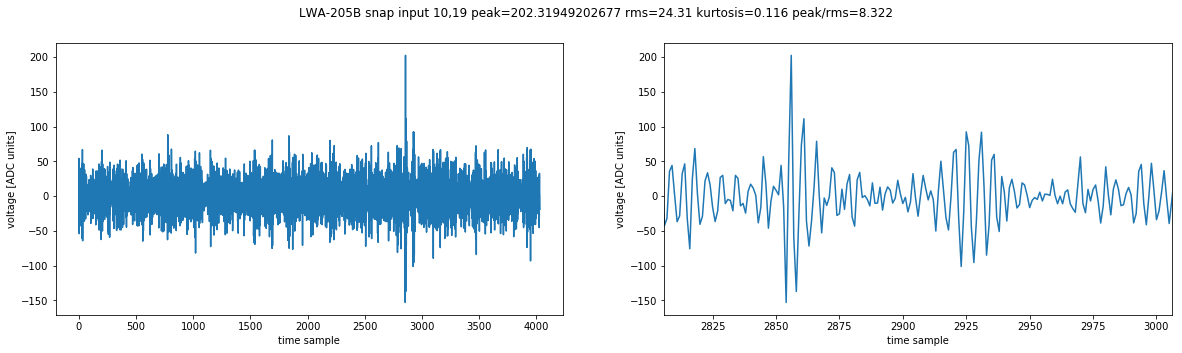

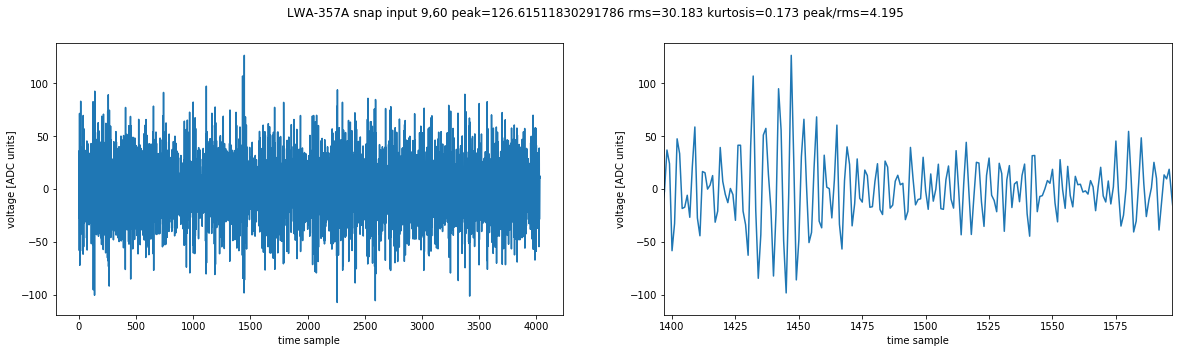

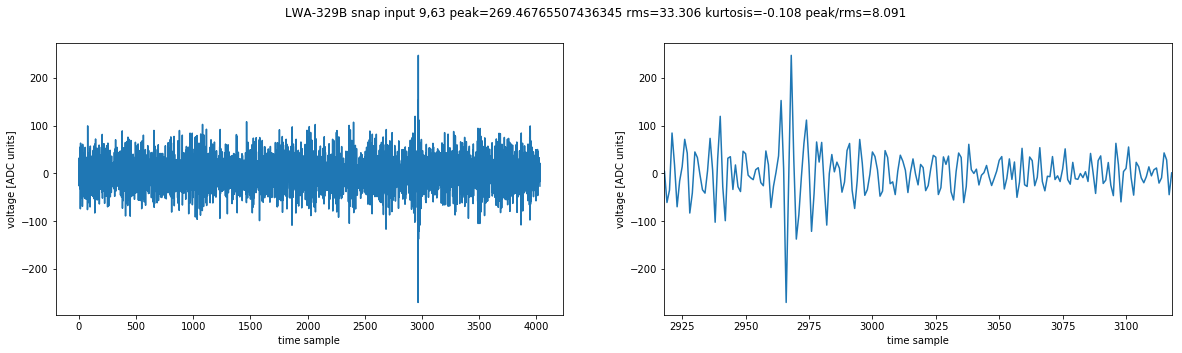

In [80]:
#with the filter
merged=mergepolarizations(event_records,arraymapdictionaries,Filter=h)

frmsA=np.asarray([record['rmsA'] for record in merged])
fpeakA=np.asarray([record['peakA'] for record in merged])
frmsB=np.asarray([record['rmsB'] for record in merged])
fpeakB=np.asarray([record['peakB'] for record in merged])
fpeak_to_rmsA=fpeakA/frmsA
fpeak_to_rmsB=fpeakB/frmsB
fkurtosisA=np.asarray([record['kurtosisA'] for record in merged])
fkurtosisB=np.asarray([record['kurtosisB'] for record in merged])

plot_event_peak_to_rms(event_records,arraymapdictionaries,minimum_ok_rms=20,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False,Filter=h)
plot_event_toas(event_records,arraymapdictionaries,minimum_ok_rms=20,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False,Filter=h)

coreA,coreB,farA,farB=rank_by_snr(event_records,arraymapdictionaries,minimum_ok_rms=20,maximum_ok_rms=45,Filter=h)
for rankedlist in coreA,coreB,farA,farB:
    if len(rankedlist)>1:
        plot_timeseries(event_records,[A[1] for A in rankedlist[:1]],zoom='peak',Filter=h)
    else:
        plot_timeseries(event_records,[A[1] for A in rankedlist],zoom='peak',Filter=h)


Median (peakA/fpeakA)  1.4989045718165785
Median (peakB/fpeakB)  1.3500739174232885
Median (rmsA/frmsA)  1.4646319724165244
Median (rmsB/frmsB)  1.4811521159519305
Median (kurtosisA/fkurtosisA)  0.6683499629281613
Median (kurtosisB/fkurtosisB)  0.499689780265153
Median (snrA/fsnrA)  0.9799450095489828
Median (snrB/fsnrB)  0.894284320666525


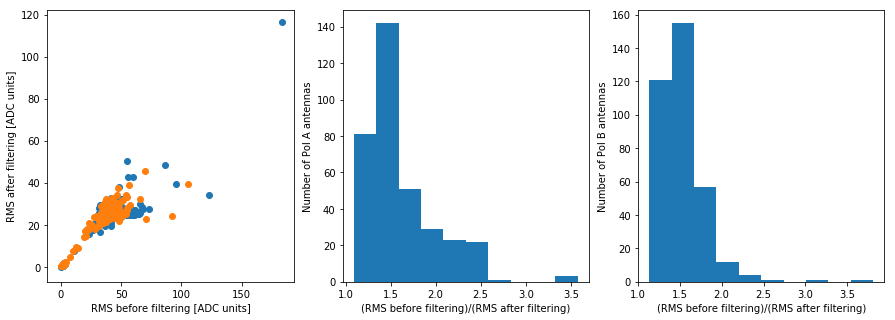

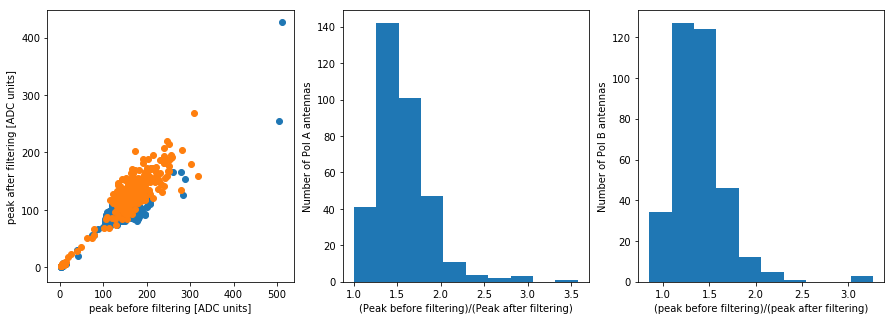

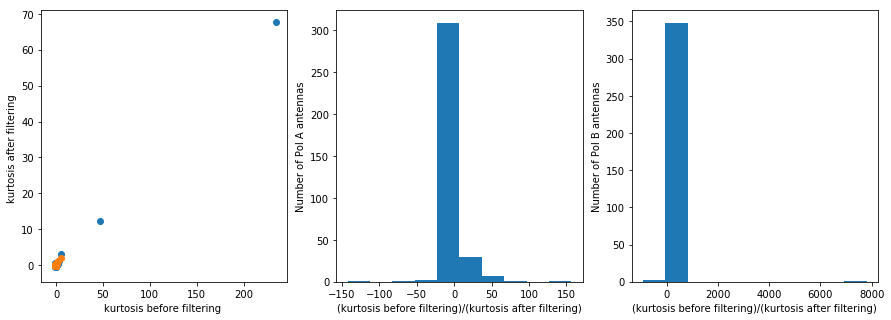

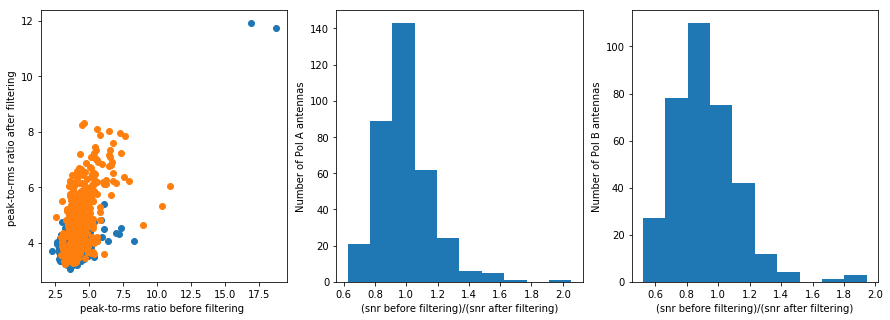

In [81]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(rmsA,frmsA,label='pol A')
plt.scatter(rmsB,frmsB,label='pol B')
plt.xlabel('RMS before filtering [ADC units]')
plt.ylabel('RMS after filtering [ADC units]')
plt.subplot(132)
plt.hist(rmsA/frmsA)
plt.xlabel('(RMS before filtering)/(RMS after filtering)')
plt.ylabel('Number of Pol A antennas' )
plt.subplot(133)
plt.hist(rmsB/frmsB)
plt.xlabel('(RMS before filtering)/(RMS after filtering)')
plt.ylabel('Number of Pol B antennas' )

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(peakA,fpeakA,label='pol A')
plt.scatter(peakB,fpeakB,label='pol B')
plt.xlabel('peak before filtering [ADC units]')
plt.ylabel('peak after filtering [ADC units]' )
plt.subplot(132)
plt.hist(peakA/fpeakA)
plt.xlabel('(Peak before filtering)/(Peak after filtering)')
plt.ylabel('Number of Pol A antennas' )
plt.subplot(133)
plt.hist(peakB/fpeakB)
plt.xlabel('(peak before filtering)/(peak after filtering)')
plt.ylabel('Number of Pol B antennas' )

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(kurtosisA,fkurtosisA,label='pol A')
plt.scatter(kurtosisB,fkurtosisB,label='pol B')
plt.xlabel('kurtosis before filtering ')
plt.ylabel('kurtosis after filtering ' )
plt.subplot(132)
plt.hist(kurtosisA/fkurtosisA)
plt.xlabel('(kurtosis before filtering)/(kurtosis after filtering)')
plt.ylabel('Number of Pol A antennas' )
plt.subplot(133)
plt.hist(kurtosisB/fkurtosisB)
plt.xlabel('(kurtosis before filtering)/(kurtosis after filtering)')
plt.ylabel('Number of Pol B antennas' )

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(peak_to_rmsA,fpeak_to_rmsA,label='pol A')
plt.scatter(peak_to_rmsB,fpeak_to_rmsB, label='pol B')
plt.xlabel('peak-to-rms ratio before filtering ')
plt.ylabel('peak-to-rms ratio after filtering ' )
plt.subplot(132)
plt.hist(peak_to_rmsA/fpeak_to_rmsA)
plt.xlabel('(snr before filtering)/(snr after filtering)')
plt.ylabel('Number of Pol A antennas' )
plt.subplot(133)
plt.hist(peak_to_rmsB/fpeak_to_rmsB)
plt.xlabel('(snr before filtering)/(snr after filtering)')
plt.ylabel('Number of Pol B antennas' )


print("Median (peakA/fpeakA) ",np.median(peakA/fpeakA))
print("Median (peakB/fpeakB) ",np.median(peakB/fpeakB))

print("Median (rmsA/frmsA) ",np.median(rmsA/frmsA))
print("Median (rmsB/frmsB) ",np.median(rmsB/frmsB))

print("Median (kurtosisA/fkurtosisA) ",np.median(kurtosisA/fkurtosisA))
print("Median (kurtosisB/fkurtosisB) ",np.median(kurtosisB/fkurtosisB))

print("Median (snrA/fsnrA) ",np.median(peak_to_rmsA/fpeak_to_rmsA))
print("Median (snrB/fsnrB) ",np.median(peak_to_rmsB/fpeak_to_rmsB))



### Another Example Event

/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':
/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:218: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':
/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More t

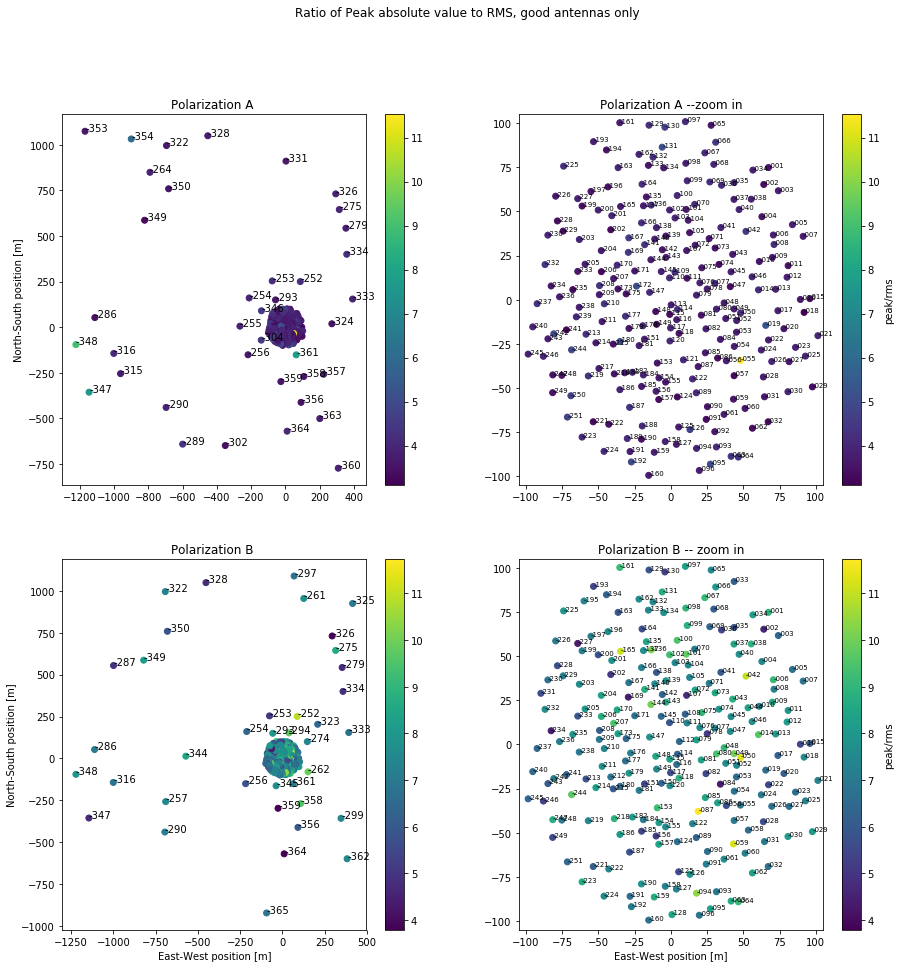

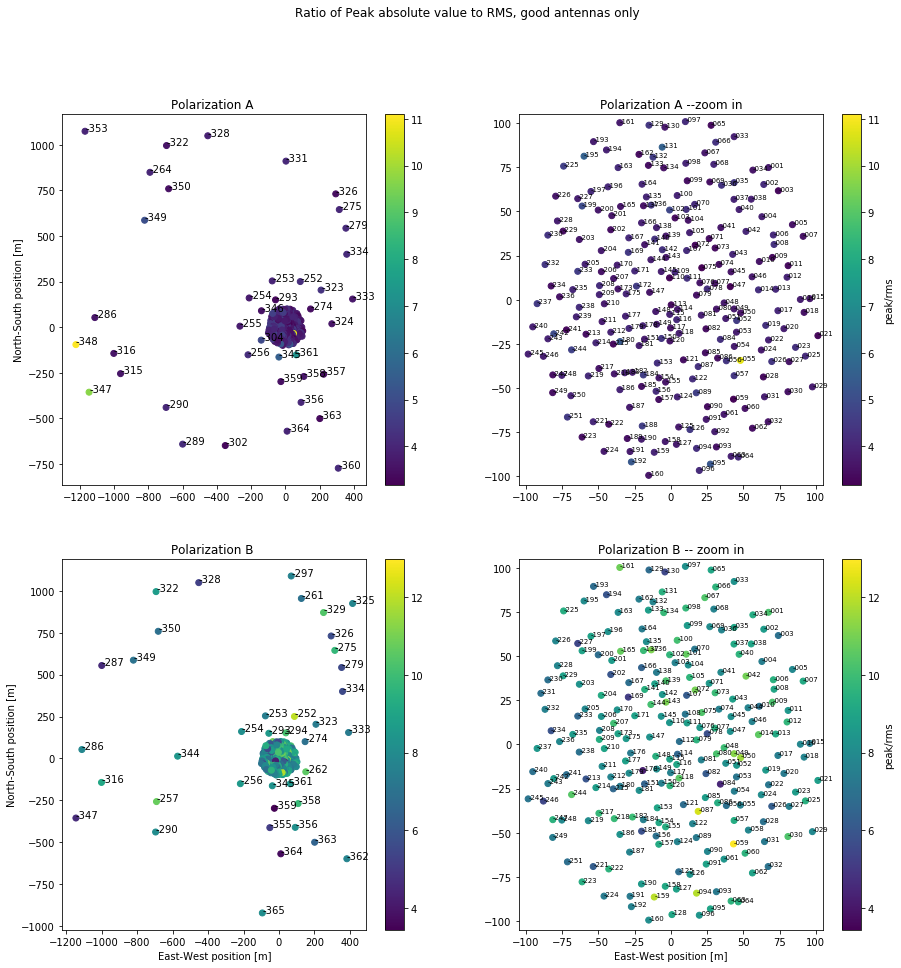

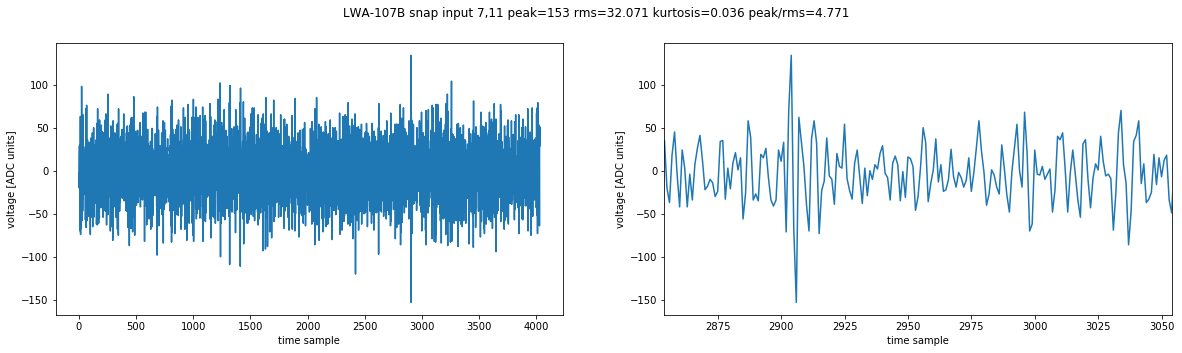

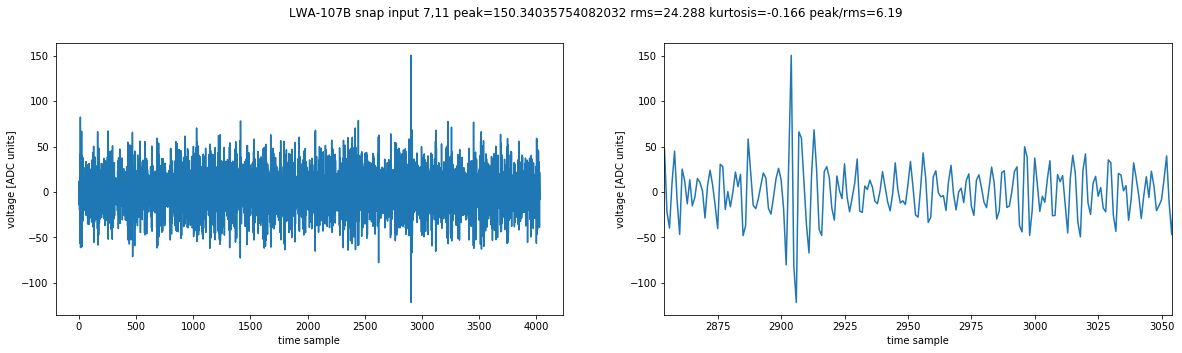

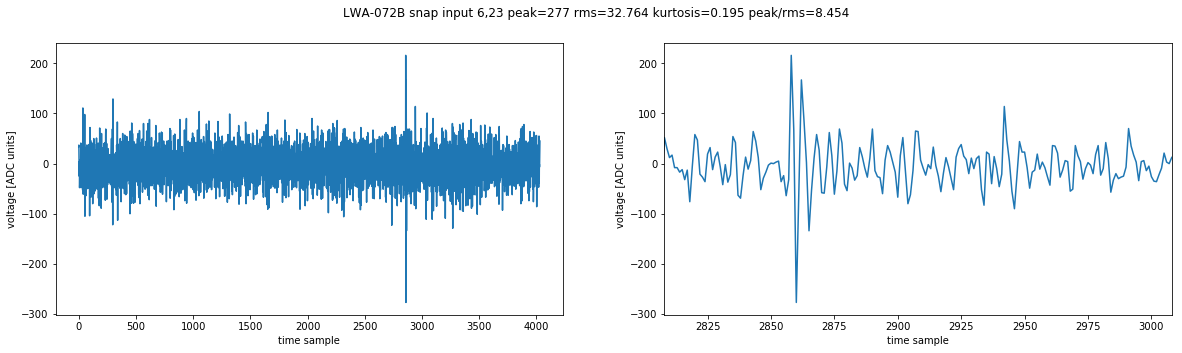

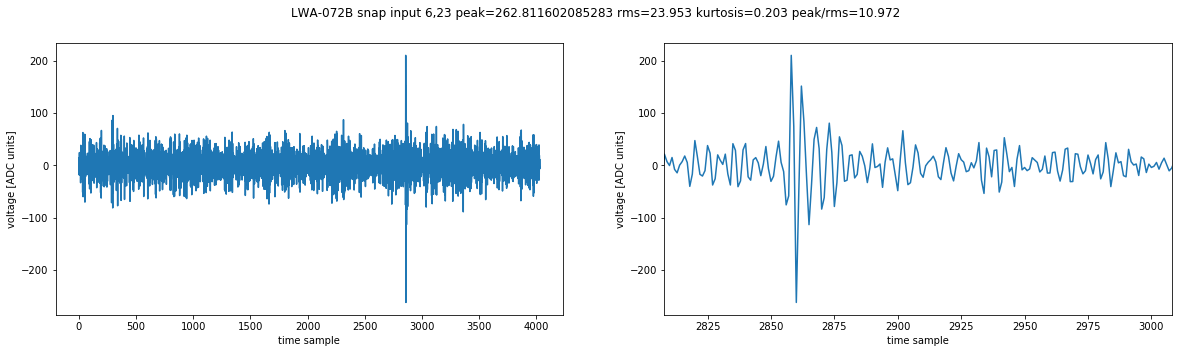

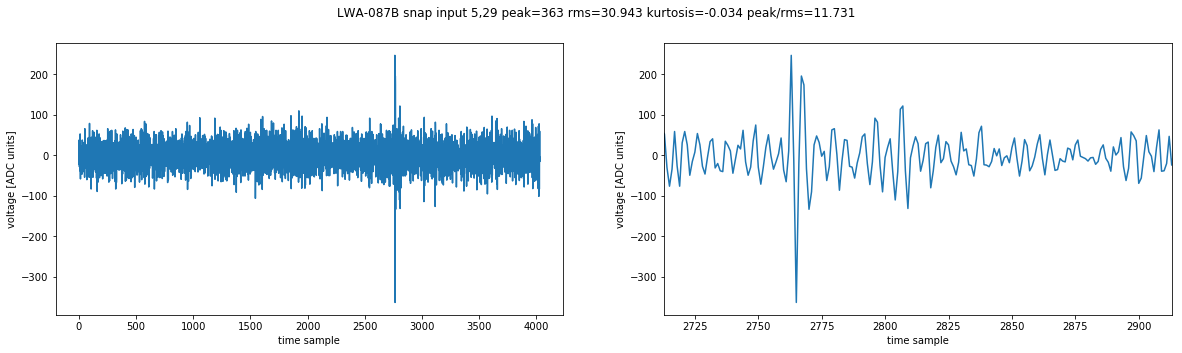

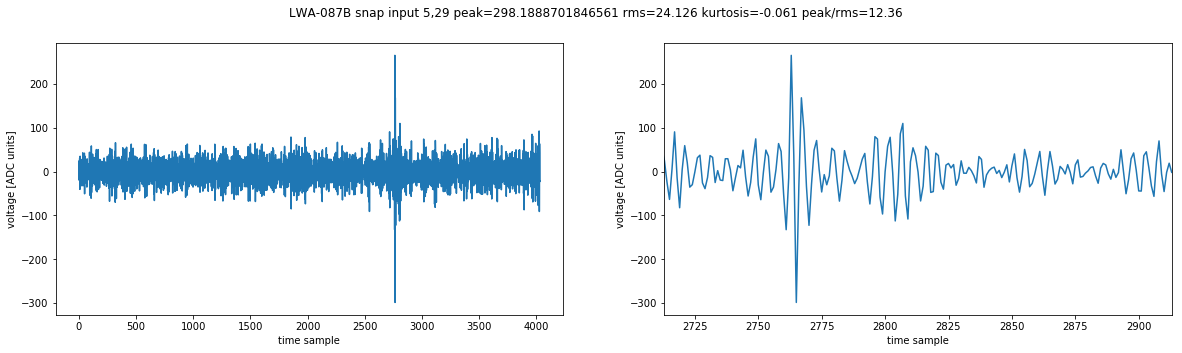

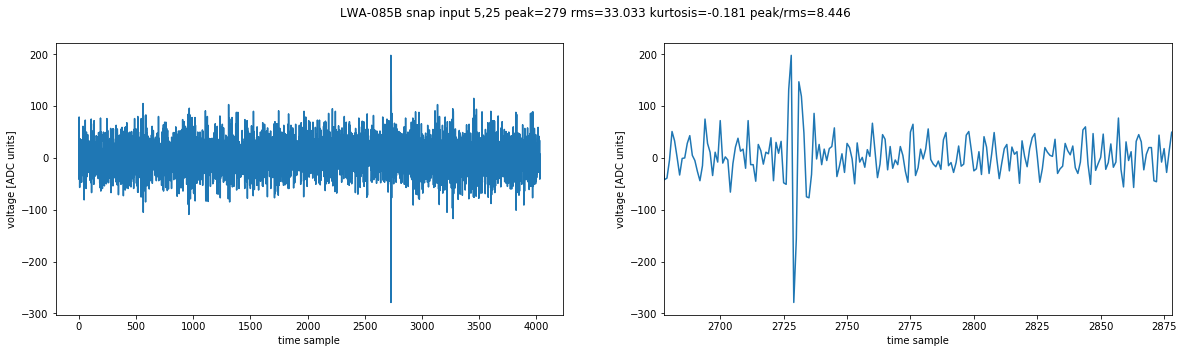

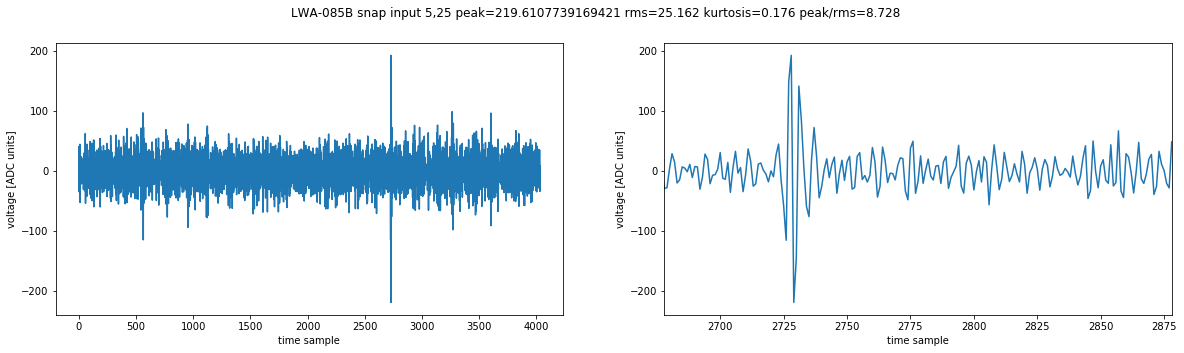

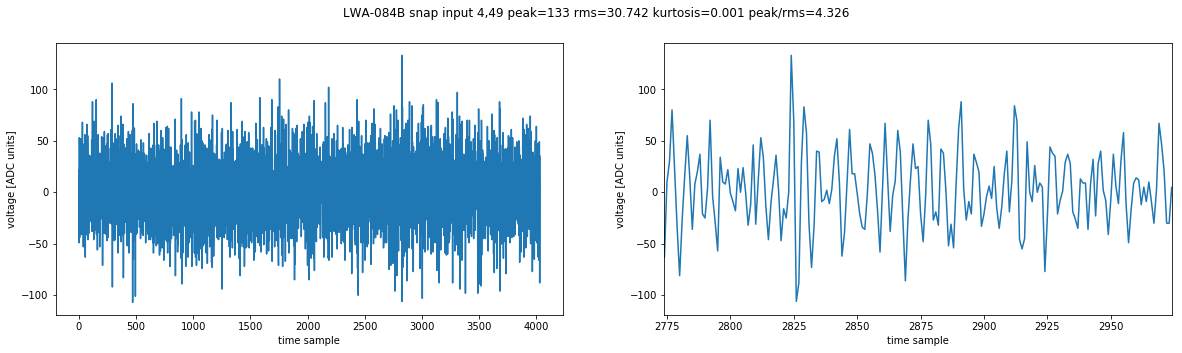

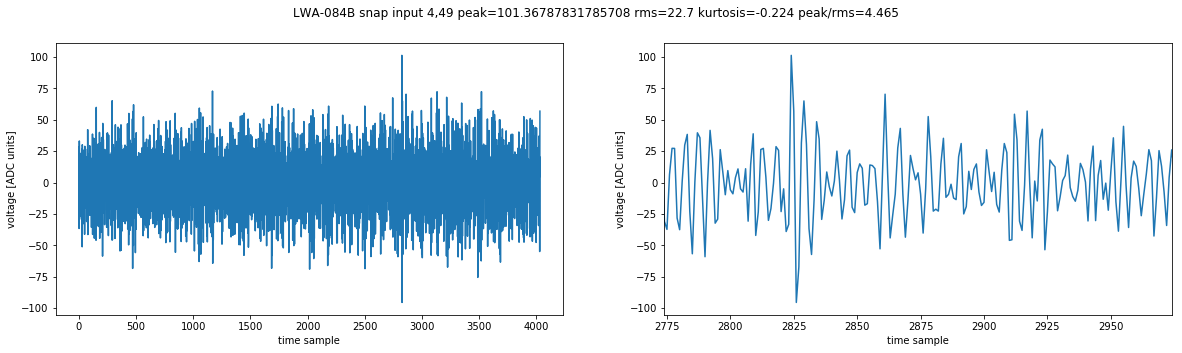

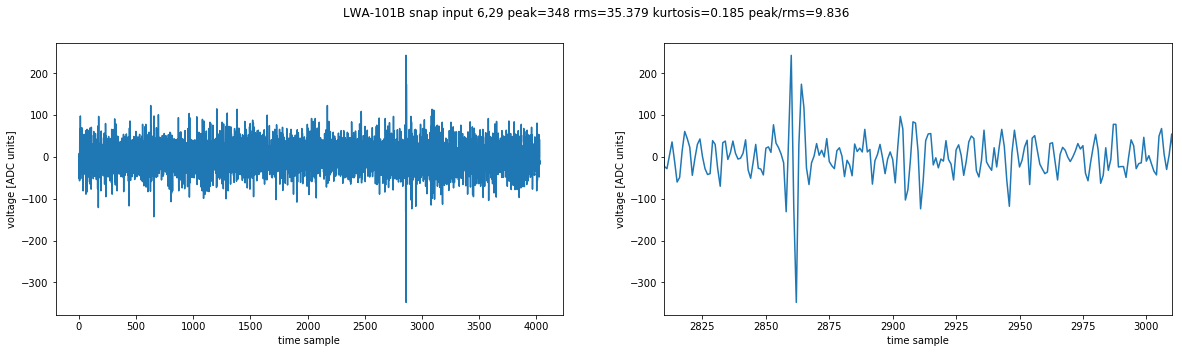

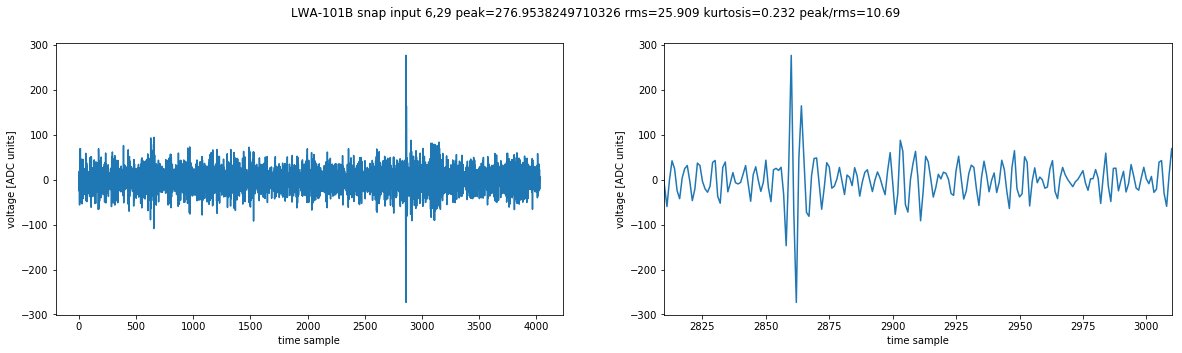

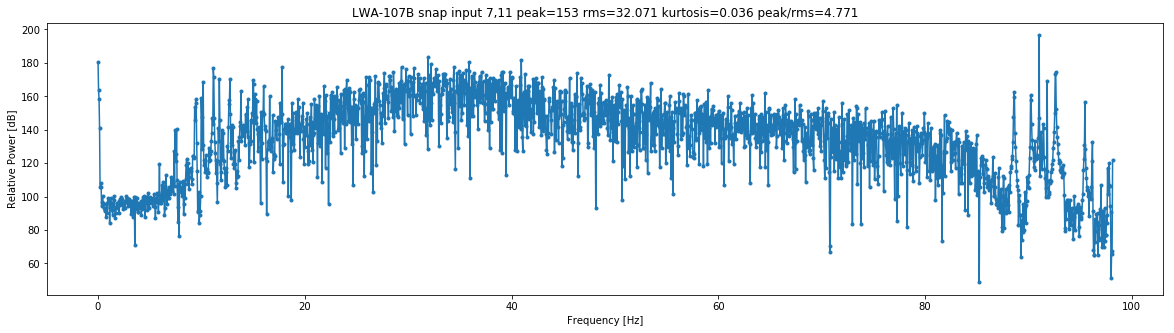

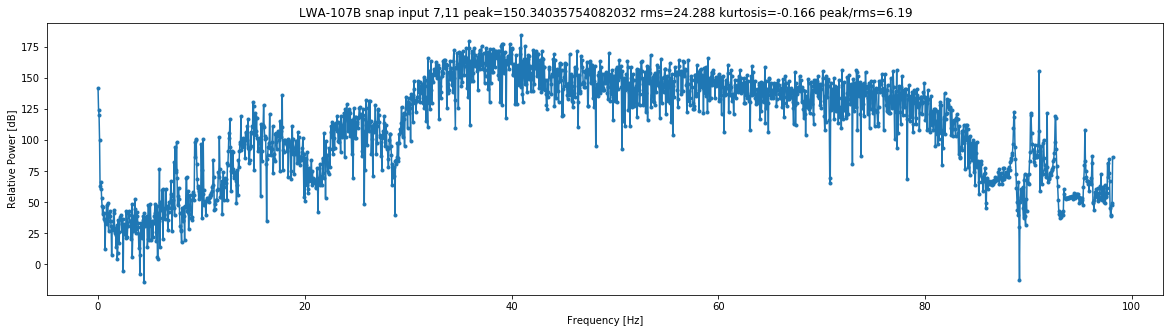

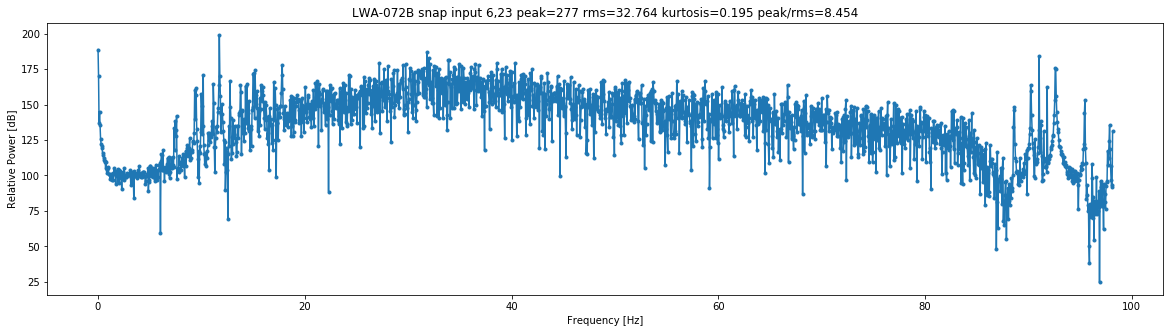

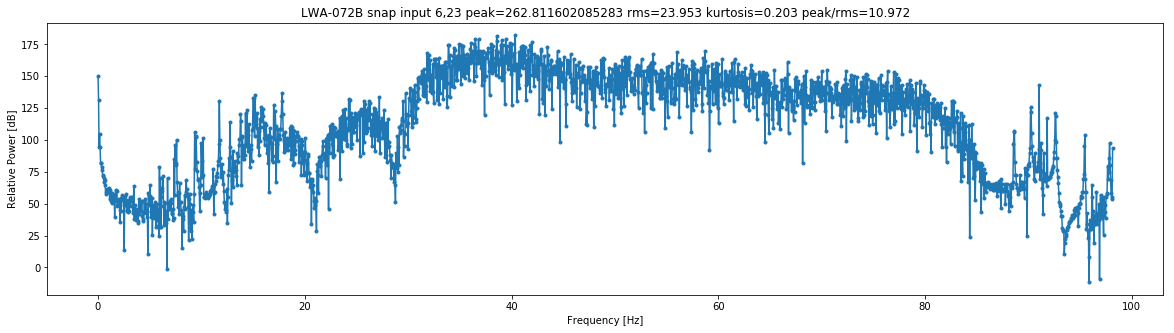

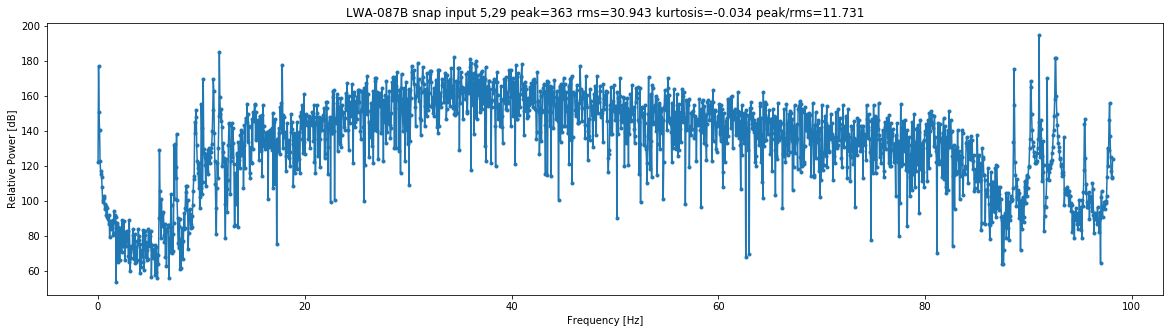

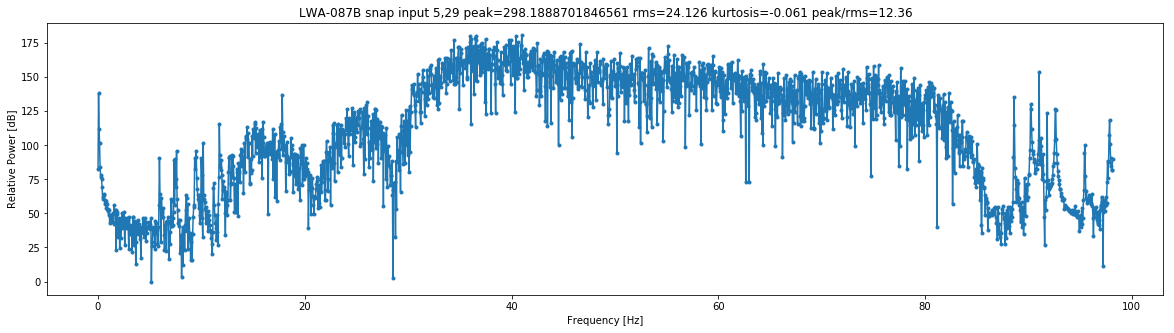

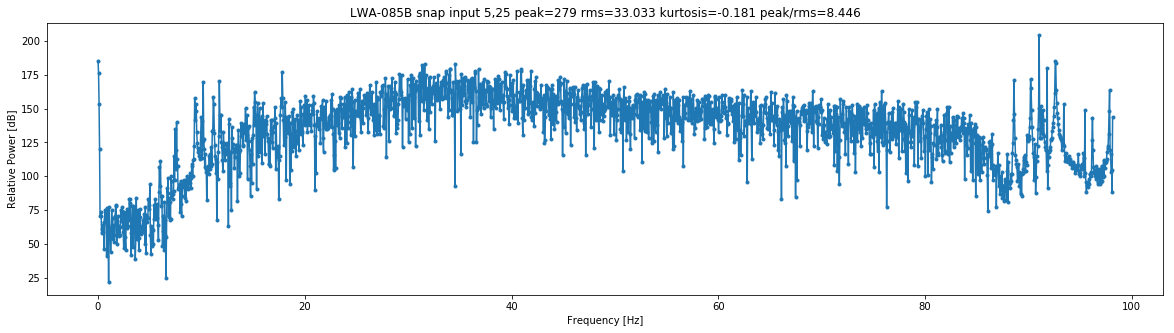

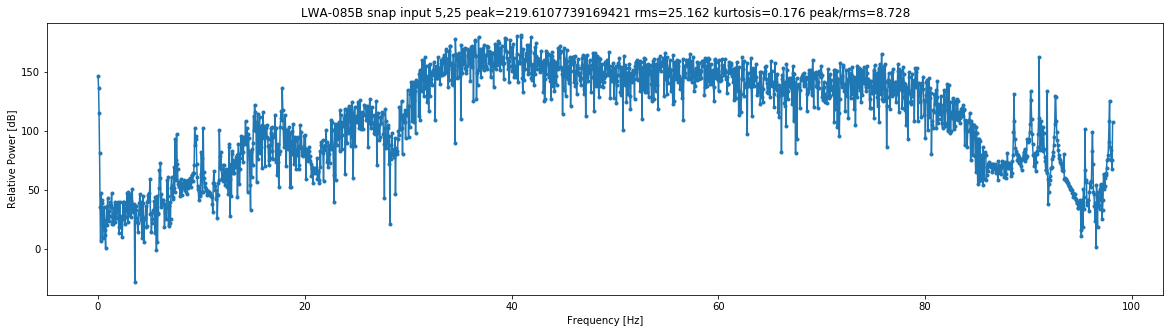

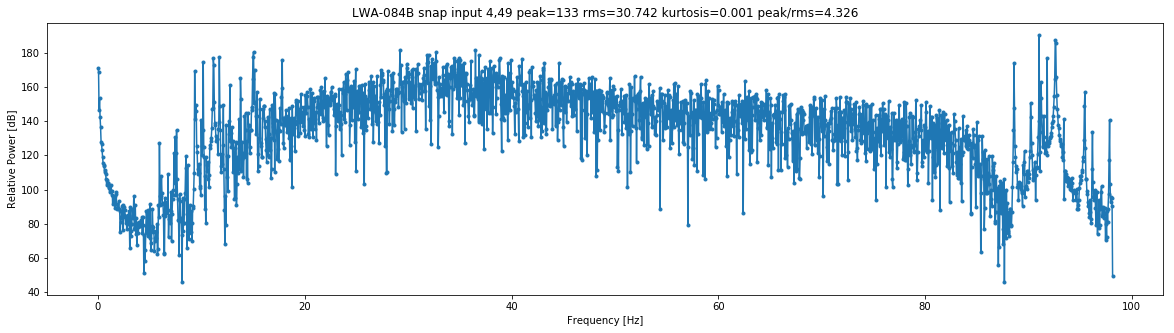

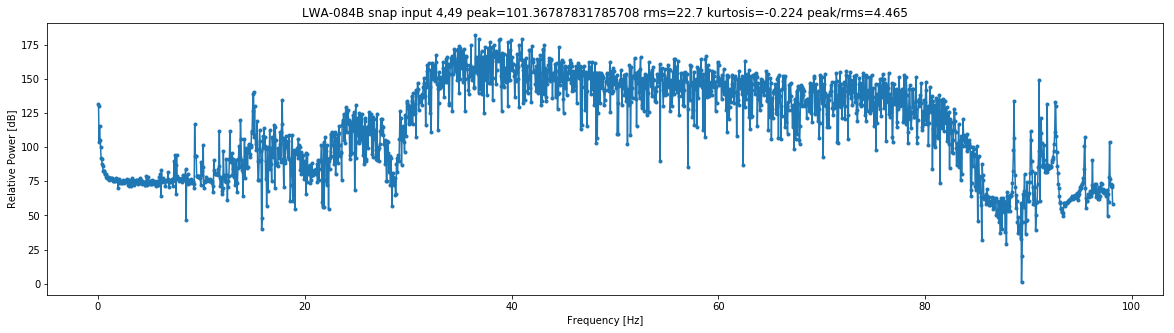

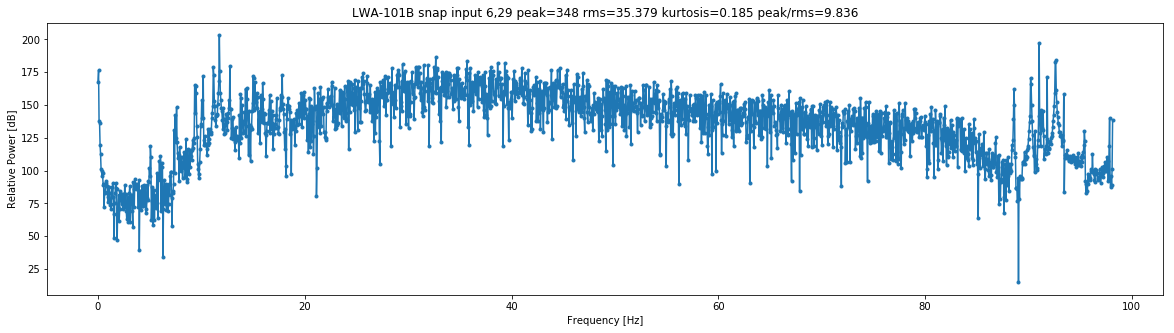

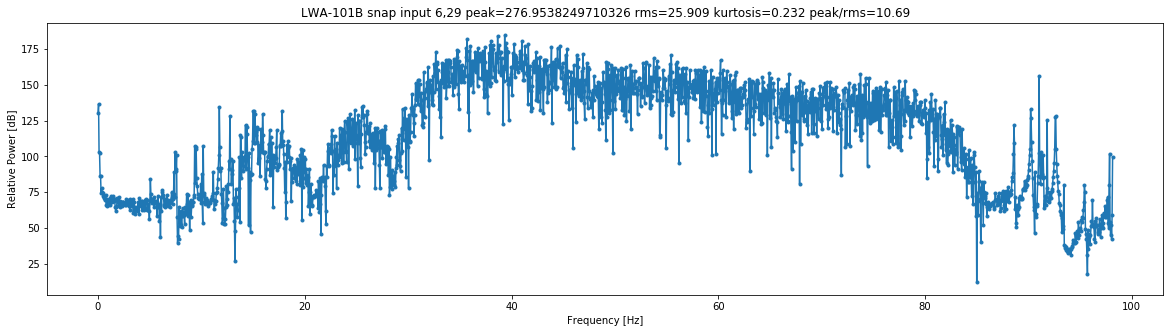

In [93]:
#load the desired event

datafname ='overnight1683181915.1232927.dat' 
i=129791

event_records=parsefile(datadir+datafname,start_ind=i,end_ind=704 )

#without the filter
merged=mergepolarizations(event_records,arraymapdictionaries)
rmsA=np.asarray([record['rmsA'] for record in merged])
peakA=np.asarray([record['peakA'] for record in merged])
rmsB=np.asarray([record['rmsB'] for record in merged])
peakB=np.asarray([record['peakB'] for record in merged])
peak_to_rmsA=fpeakA/frmsA
peak_to_rmsB=fpeakB/frmsB
kurtosisA=np.asarray([record['kurtosisA'] for record in merged])
kurtosisB=np.asarray([record['kurtosisB'] for record in merged])

plot_event_peak_to_rms(event_records,arraymapdictionaries,minimum_ok_rms=15,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=True)
##plot_event_toas(event_records,arraymapdictionaries,minimum_ok_rms=20,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=True)

'''coreA,coreB,farA,farB=rank_by_snr(event_records,arraymapdictionaries,minimum_ok_rms=20,maximum_ok_rms=45)
for rankedlist in coreA,coreB,farA,farB:
    if len(rankedlist)>1:
        plot_timeseries(event_records,[A[1] for A in rankedlist[:1]],zoom='peak')
    else:
        plot_timeseries(event_records,[A[1] for A in rankedlist],zoom='peak')'''

#with the filter
merged=mergepolarizations(event_records,arraymapdictionaries,Filter=h)
frmsA=np.asarray([record['rmsA'] for record in merged])
fpeakA=np.asarray([record['peakA'] for record in merged])
frmsB=np.asarray([record['rmsB'] for record in merged])
fpeakB=np.asarray([record['peakB'] for record in merged])
fpeak_to_rmsA=fpeakA/frmsA
fpeak_to_rmsB=fpeakB/frmsB
fkurtosisA=np.asarray([record['kurtosisA'] for record in merged])
fkurtosisB=np.asarray([record['kurtosisB'] for record in merged])

plot_event_peak_to_rms(event_records,arraymapdictionaries,minimum_ok_rms=15,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=True,Filter=h)
##plot_event_toas(event_records,arraymapdictionaries,minimum_ok_rms=20,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=True,Filter=h)


'''coreA,coreB,farA,farB=rank_by_snr(event_records,arraymapdictionaries,minimum_ok_rms=20,maximum_ok_rms=45,Filter=h)
for rankedlist in coreA,coreB,farA,farB:
    if len(rankedlist)>1:
        plot_timeseries(event_records,[A[1] for A in rankedlist[:1]],zoom='peak',Filter=h)
    else:
        plot_timeseries(event_records,[A[1] for A in rankedlist],zoom='peak',Filter=h)'''

#plot certain antennas with and without filter
interesting_antennas=['LWA-107B','LWA-072B','LWA-087B','LWA-085B','LWA-084B','LWA-101B']
for A in interesting_antennas:
    plot_timeseries(event_records,A,zoom='peak',Filter='None')
    plot_timeseries(event_records,A,zoom='peak',Filter=h)
for A in interesting_antennas:
    plot_spectra(event_records,A,Filter='None')
    plot_spectra(event_records,A,Filter=h)

/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':


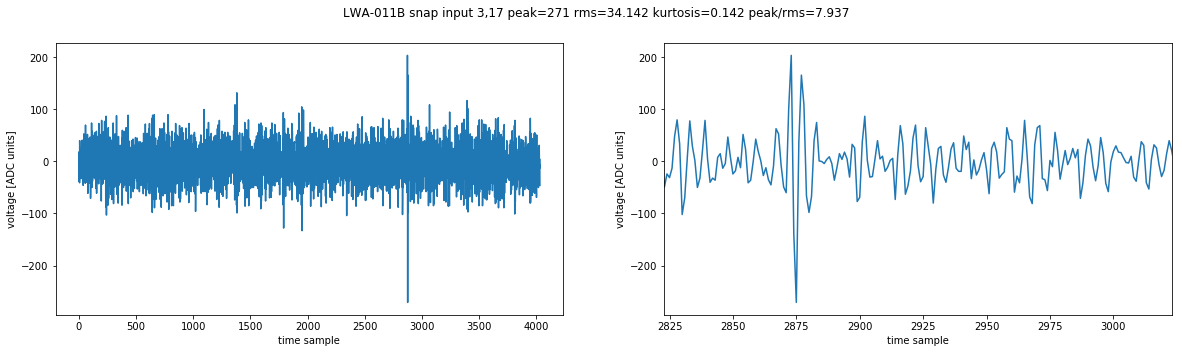

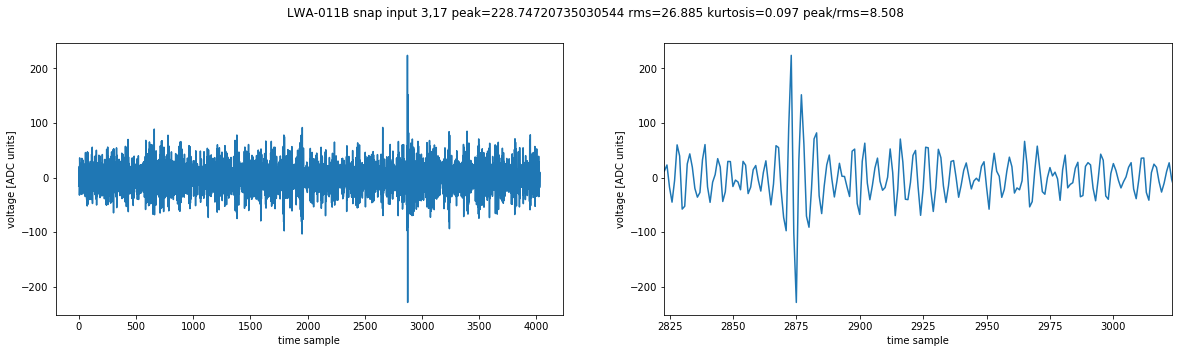

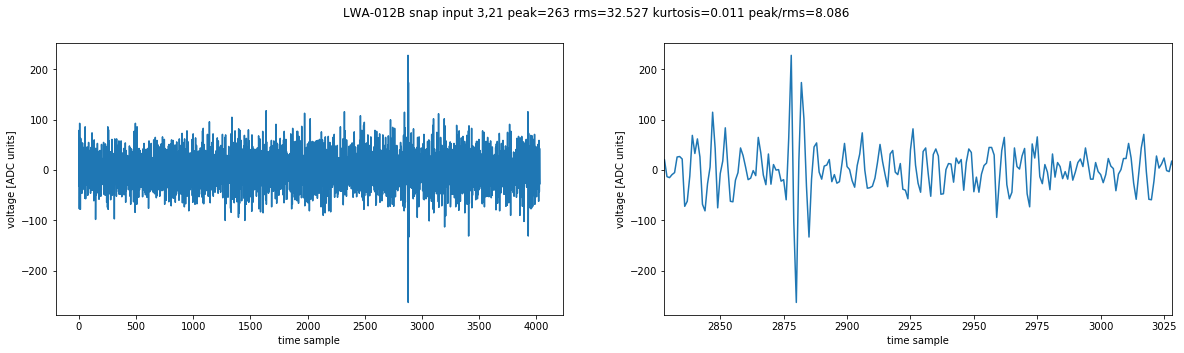

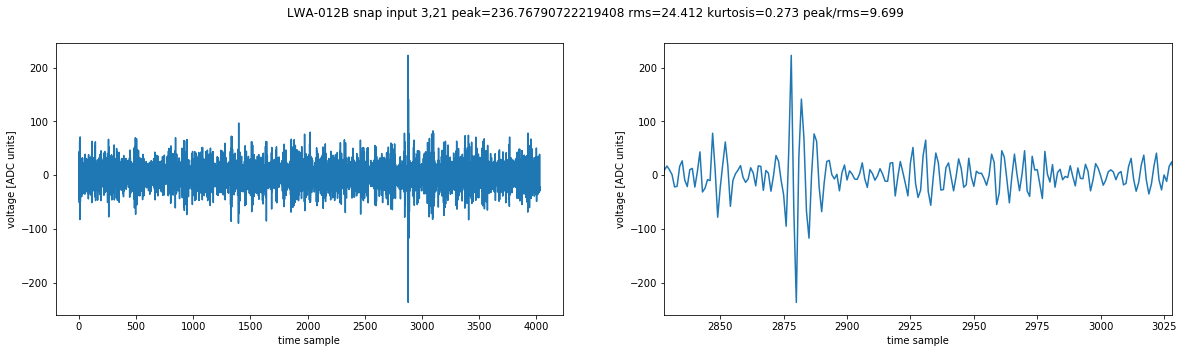

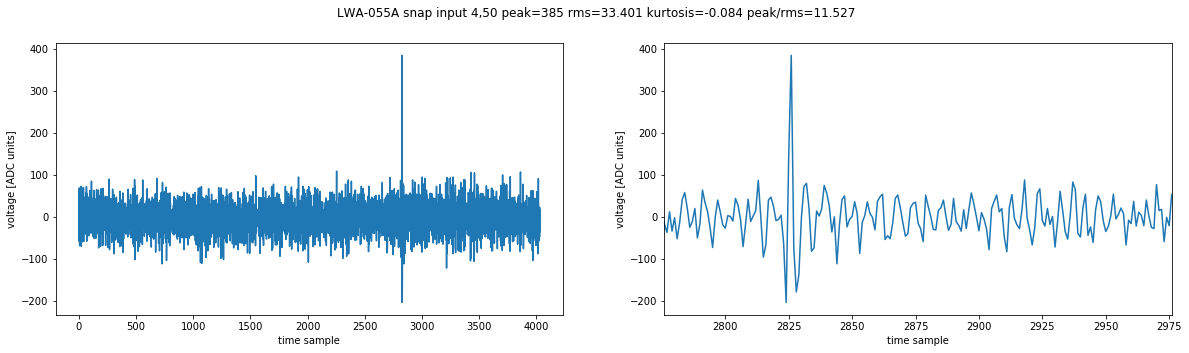

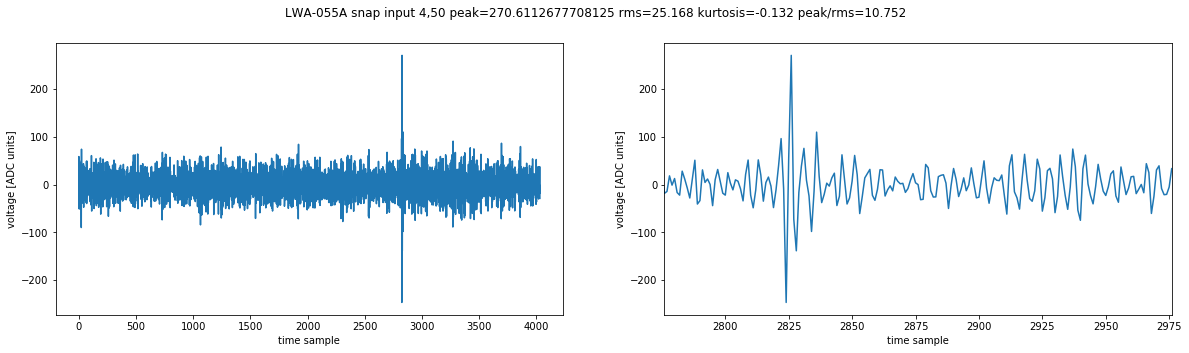

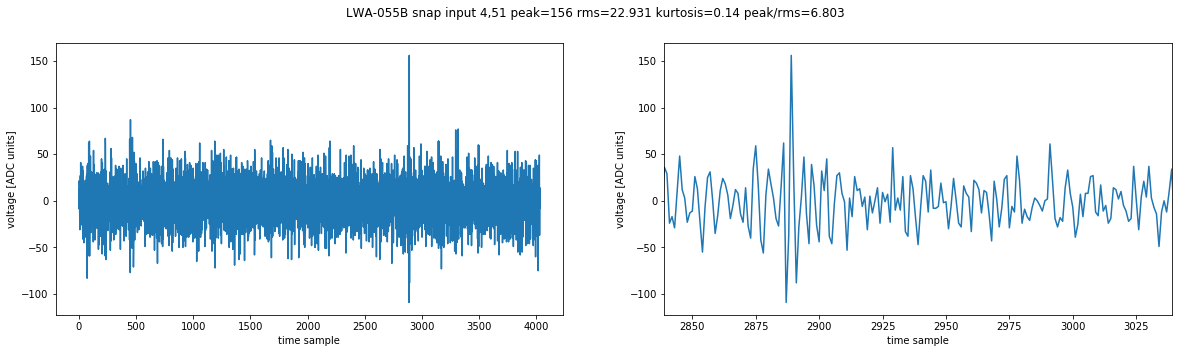

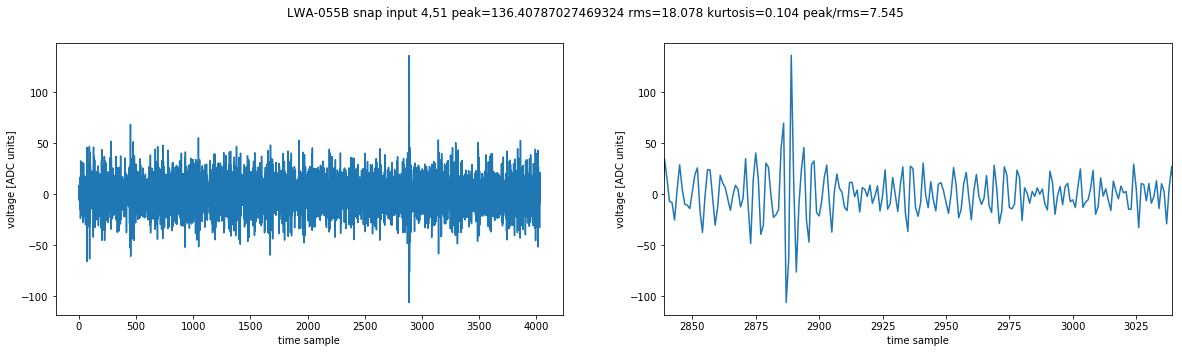

In [83]:
interesting_antennas=['LWA-011B','LWA-012B','LWA-055A','LWA-055B']
for A in interesting_antennas:
    plot_timeseries(event_records,A,zoom='peak',Filter='None')
    plot_timeseries(event_records,A,zoom='peak',Filter=h)

Median (peakA/fpeakA)  1.3560243321118093
Median (peakB/fpeakB)  1.2084891368016932
Median (rmsA/frmsA)  1.3406469999263795
Median (rmsB/frmsB)  1.3206557906466132
Median (kurtosisA/fkurtosisA)  0.5381685365596294
Median (kurtosisB/fkurtosisB)  0.4848039907614333
Median (snrA/fsnrA)  0.9797515662640365
Median (snrB/fsnrB)  0.6650325473511715


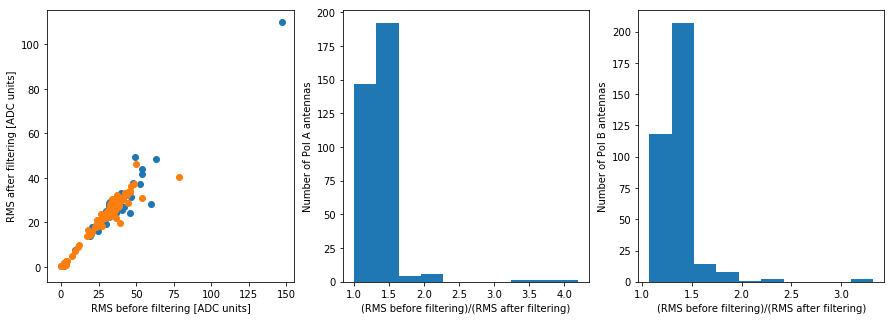

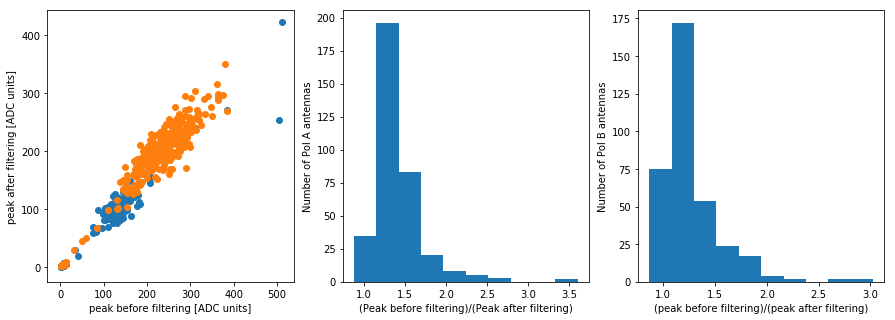

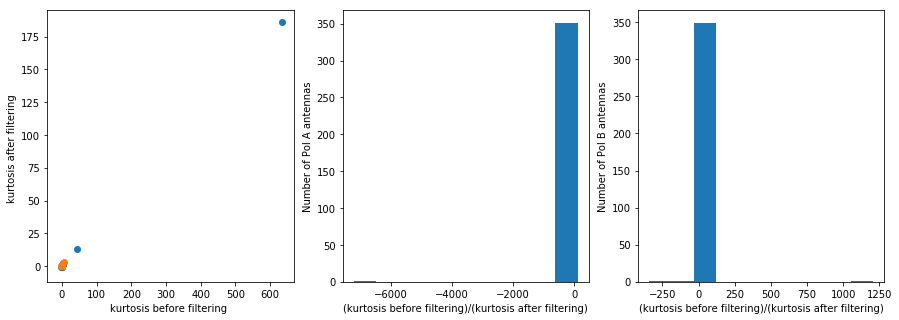

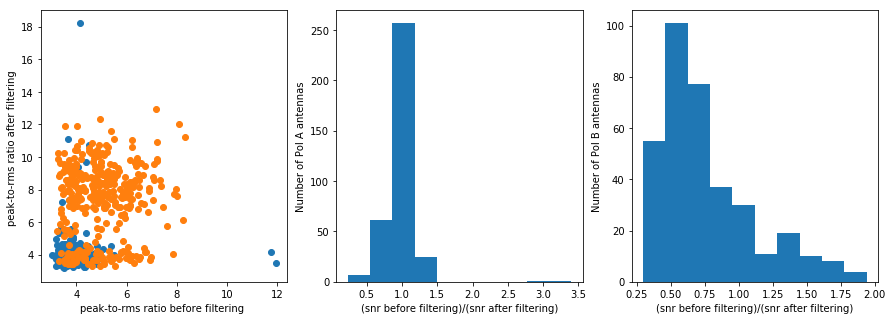

In [84]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(rmsA,frmsA,label='pol A')
plt.scatter(rmsB,frmsB,label='pol B')
plt.xlabel('RMS before filtering [ADC units]')
plt.ylabel('RMS after filtering [ADC units]')
plt.subplot(132)
plt.hist(rmsA/frmsA)
plt.xlabel('(RMS before filtering)/(RMS after filtering)')
plt.ylabel('Number of Pol A antennas' )
plt.subplot(133)
plt.hist(rmsB/frmsB)
plt.xlabel('(RMS before filtering)/(RMS after filtering)')
plt.ylabel('Number of Pol B antennas' )

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(peakA,fpeakA,label='pol A')
plt.scatter(peakB,fpeakB,label='pol B')
plt.xlabel('peak before filtering [ADC units]')
plt.ylabel('peak after filtering [ADC units]' )
plt.subplot(132)
plt.hist(peakA/fpeakA)
plt.xlabel('(Peak before filtering)/(Peak after filtering)')
plt.ylabel('Number of Pol A antennas' )
plt.subplot(133)
plt.hist(peakB/fpeakB)
plt.xlabel('(peak before filtering)/(peak after filtering)')
plt.ylabel('Number of Pol B antennas' )

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(kurtosisA,fkurtosisA,label='pol A')
plt.scatter(kurtosisB,fkurtosisB,label='pol B')
plt.xlabel('kurtosis before filtering ')
plt.ylabel('kurtosis after filtering ' )
plt.subplot(132)
plt.hist(kurtosisA/fkurtosisA)
plt.xlabel('(kurtosis before filtering)/(kurtosis after filtering)')
plt.ylabel('Number of Pol A antennas' )
plt.subplot(133)
plt.hist(kurtosisB/fkurtosisB)
plt.xlabel('(kurtosis before filtering)/(kurtosis after filtering)')
plt.ylabel('Number of Pol B antennas' )

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(peak_to_rmsA,fpeak_to_rmsA,label='pol A')
plt.scatter(peak_to_rmsB,fpeak_to_rmsB, label='pol B')
plt.xlabel('peak-to-rms ratio before filtering ')
plt.ylabel('peak-to-rms ratio after filtering ' )
plt.subplot(132)
plt.hist(peak_to_rmsA/fpeak_to_rmsA)
plt.xlabel('(snr before filtering)/(snr after filtering)')
plt.ylabel('Number of Pol A antennas' )
plt.subplot(133)
plt.hist(peak_to_rmsB/fpeak_to_rmsB)
plt.xlabel('(snr before filtering)/(snr after filtering)')
plt.ylabel('Number of Pol B antennas' )


print("Median (peakA/fpeakA) ",np.median(peakA/fpeakA))
print("Median (peakB/fpeakB) ",np.median(peakB/fpeakB))

print("Median (rmsA/frmsA) ",np.median(rmsA/frmsA))
print("Median (rmsB/frmsB) ",np.median(rmsB/frmsB))

print("Median (kurtosisA/fkurtosisA) ",np.median(kurtosisA/fkurtosisA))
print("Median (kurtosisB/fkurtosisB) ",np.median(kurtosisB/fkurtosisB))

print("Median (snrA/fsnrA) ",np.median(peak_to_rmsA/fpeak_to_rmsA))
print("Median (snrB/fsnrB) ",np.median(peak_to_rmsB/fpeak_to_rmsB))



## SNR plot with SNR calculated from power average
New approach will be:

1.Noise=mean of smoothed square of timeseries

2.Peak=maximum of smoothed square of timeseries

3.snr=Peak/noise


In [116]:
def plot_event_smoothed_power_snr(event,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False,Filter='None'):
    #Plots thesnr, over the antenna positions of the array
    #Event is a list of records (single-packet dictionaries) belonging to the same event
    #Antennas are filtered to only plot antennas whose signals (in the first half of the buffer) are within the
    #bounds set by minimum_ok_rms, maximum_ok_rms, minimum_ok_kurtosis, maximum_ok_kurtosis
    #Antennas are labelled if annotate=True
    #Filter can be None or a 1D numpy array of coefficients for a time-domain FIR. If filter is not none, the timeseries will be convolved with the provided coefficients during the mergepolarizations function.
    mergedrecords=mergepolarizations(event,arraymapdictionaries,Filter)
    
    #estimate peak and noise from smoothed power after filtering (if a filter is given)
    n=4
    for record in mergedrecords:
        for p in ['A','B']:
            timeseries=record['pol'+p+'_data']
            if Filter!='None':
                timeseries=signal.convolve(timeseries,Filter,mode='same')
            powertimeseries=np.square(timeseries)
            n_tap_window_average=(1/n)*np.ones(n)
            smoothed=signal.convolve(powertimeseries,n_tap_window_average,mode='same')
            peaksmoothed=np.max(smoothed)
            meansmoothed=np.mean(smoothed[:2000])
            record['peaksmoothed'+p]=peaksmoothed
            record['meansmoothed'+p]=meansmoothed
        
    xcoords=np.asarray([record['x'] for record in mergedrecords])
    ycoords=np.asarray([record['y'] for record in mergedrecords])
    zcoords=np.asarray([record['z'] for record in mergedrecords])
    antnames=[record['antname'] for record in mergedrecords]
    
    #get smoothed peak for all antennas
    peaksmoothedA=np.asarray([record['peaksmoothedA'] for record in mergedrecords])
    peaksmoothedB=np.asarray([record['peaksmoothedB'] for record in mergedrecords])
    
    #get noise estimate
    meansmoothedA=np.asarray([record['meansmoothedA'] for record in mergedrecords])
    meansmoothedB=np.asarray([record['meansmoothedB'] for record in mergedrecords])
    
    #get snr
    snrA=peaksmoothedA/meansmoothedA
    snrB=peaksmoothedB/meansmoothedB

    #get rms before event
    rmsA=np.asarray([record['rmsA'] for record in mergedrecords])
    rmsB=np.asarray([record['rmsB'] for record in mergedrecords])
    
    #get kurtosis before event
    kurtosisA=np.asarray([record['kurtosisA'] for record in mergedrecords])
    kurtosisB=np.asarray([record['kurtosisB'] for record in mergedrecords])

    #define antenna cut based on rms 
    cut_rmsA = np.logical_and(rmsA >minimum_ok_rms, rmsA <maximum_ok_rms)
    cut_rmsB = np.logical_and(rmsB >minimum_ok_rms, rmsB <maximum_ok_rms)
    
    #define antenna cut based on kurtosis
    cut_kurtosisA = np.logical_and(kurtosisA >minimum_ok_kurtosis, kurtosisA <maximum_ok_kurtosis)
    cut_kurtosisB = np.logical_and(kurtosisB >minimum_ok_kurtosis, kurtosisB <maximum_ok_kurtosis)

    #combine antenna cuts
    cutA=np.logical_and(cut_rmsA,cut_kurtosisA)
    cutB=np.logical_and(cut_rmsB,cut_kurtosisB)

    select_core_antennas=(xcoords**2)+(ycoords**2)<(115**2)
    select_far_antennas=(xcoords**2)+(ycoords**2)>(115**2)  #note the core vs far cuts used in plotting are different than what's used for estimating if event is concentrated on core

    plt.figure(figsize=(15,15))
    plt.suptitle('Ratio of Peak absolute value to RMS, good antennas only')
    plt.subplot(221)
    plt.title("Polarization A")
    plt.scatter(xcoords[cutA],ycoords[cutA],c=10*np.log10(snrA)[cutA])
    plt.colorbar()
    plt.ylabel('North-South position [m]')
    if annotate:
        for i in range(len(antnames)):
            if cutA[i] and select_far_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.annotate(txt[3:], (x, y))
    
    plt.subplot(222)
    plt.title("Polarization A --zoom in")
    plt.scatter(xcoords[cutA],ycoords[cutA],c=10*np.log10(snrA)[cutA])
    plt.xlim(-105,105)
    plt.ylim(-105,105)
    plt.colorbar(label='10log(SNR)')
    #plt.clim(cmin,cmax)
    if annotate:
        for i in range(len(antnames)):
            if cutA[i] and select_core_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.text(x,y,txt[3:],fontsize='x-small')
                
    plt.subplot(223)
    plt.title("Polarization B ")
    plt.scatter(xcoords[cutB],ycoords[cutB],c=10*np.log10(snrB)[cutB])
    plt.colorbar()
    plt.xlabel('East-West position [m]')
    plt.ylabel('North-South position [m]')
    if annotate:
        for i in range(len(antnames)):
            if cutB[i] and select_far_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.annotate(txt[3:], (x, y))

    plt.subplot(224)
    plt.title("Polarization B -- zoom in")
    plt.scatter(xcoords[cutB],ycoords[cutB],c=10*np.log10(snrB)[cutB])
    plt.xlim(-105,105)
    plt.ylim(-105,105)
    plt.colorbar(label='10log(SNR)')
    plt.xlabel('East-West position [m]')
    
    if annotate:
        for i in range(len(antnames)):
            if cutB[i] and select_core_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.text(x,y,txt[3:],fontsize='x-small')

    return

/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':
/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:218: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


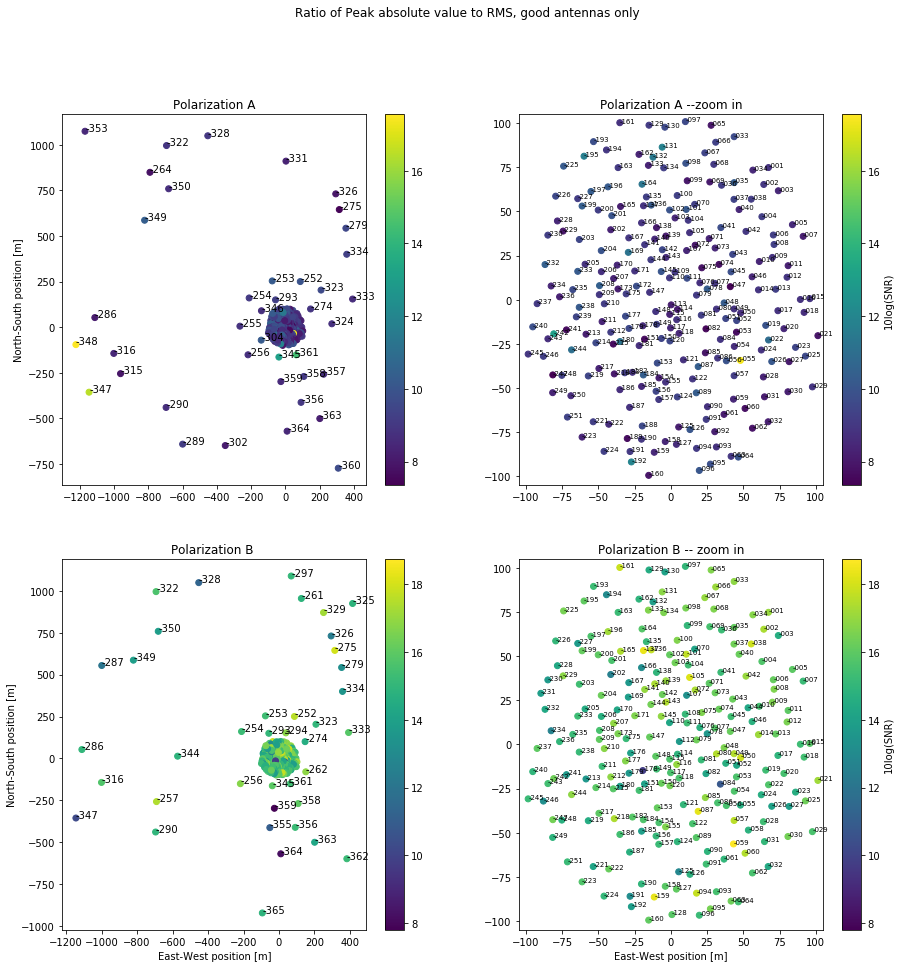

In [121]:
#load the desired event

datafname ='overnight1683181915.1232927.dat' 
i=129791

event_records=parsefile(datadir+datafname,start_ind=i,end_ind=704 )

plot_event_smoothed_power_snr(event_records,arraymapdictionaries,minimum_ok_rms=15,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=True,Filter=h)

Amplitude timeseries, No filter


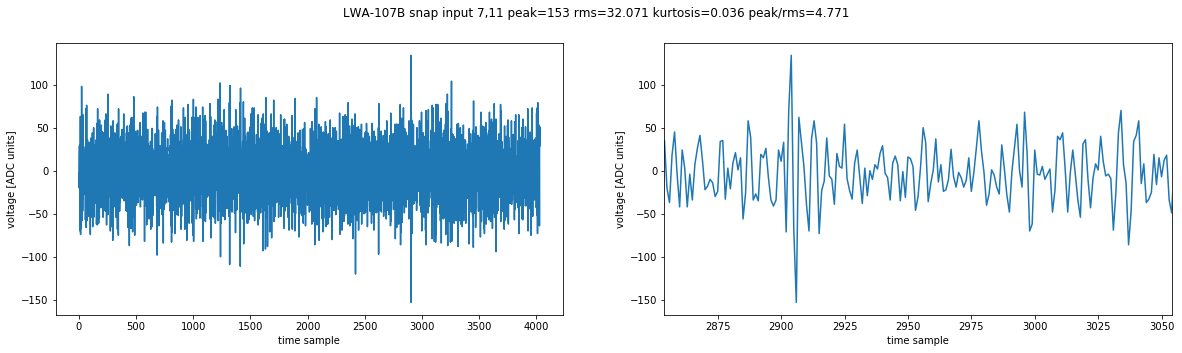

Amplitude timeseries with Filter 


/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':


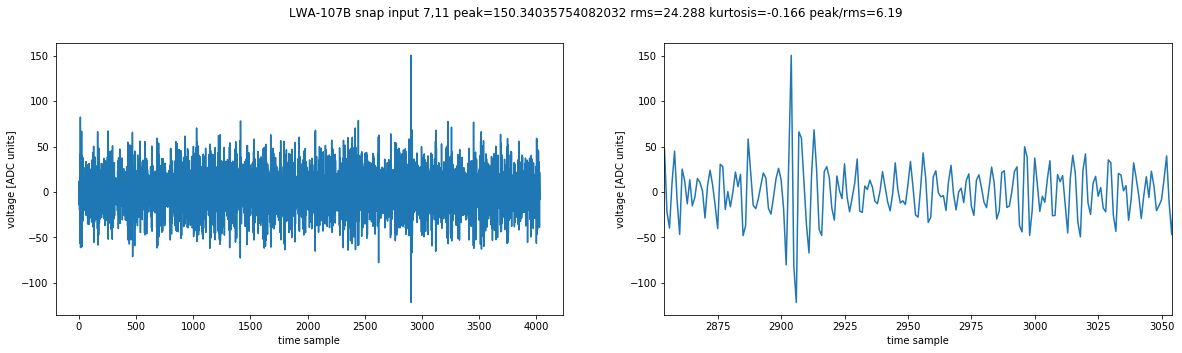

Amplitude timeseries with Filter no smoothing 


/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


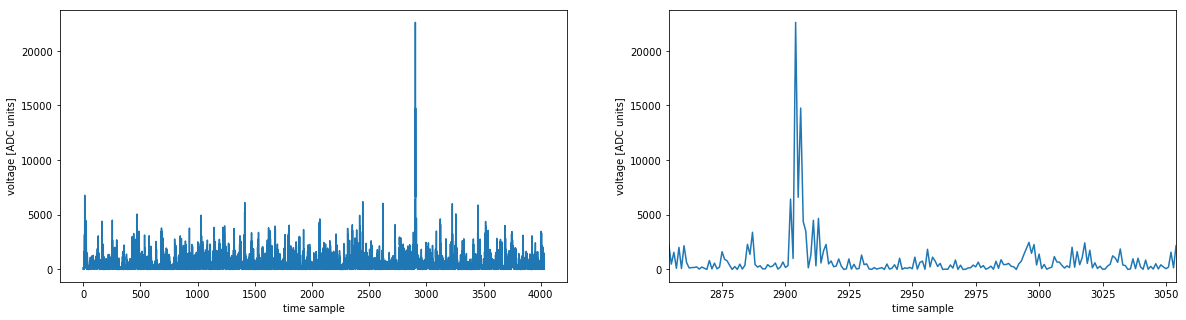

Amplitude timeseries with Filter and smoothing 


/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


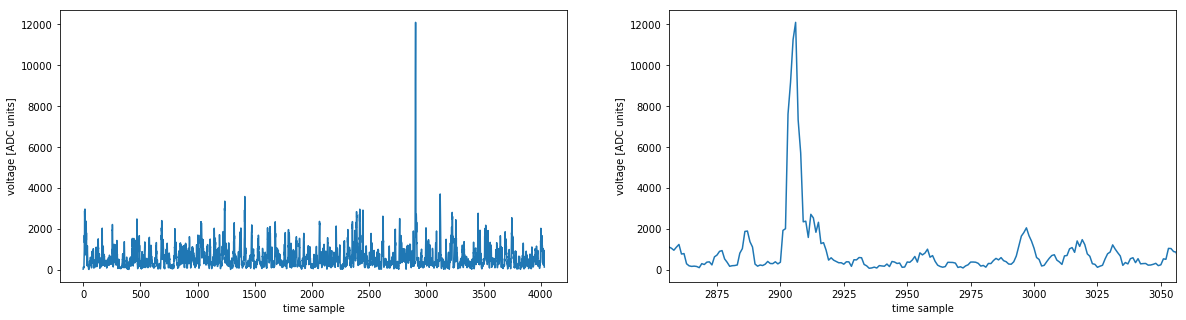

Amplitude timeseries, No filter


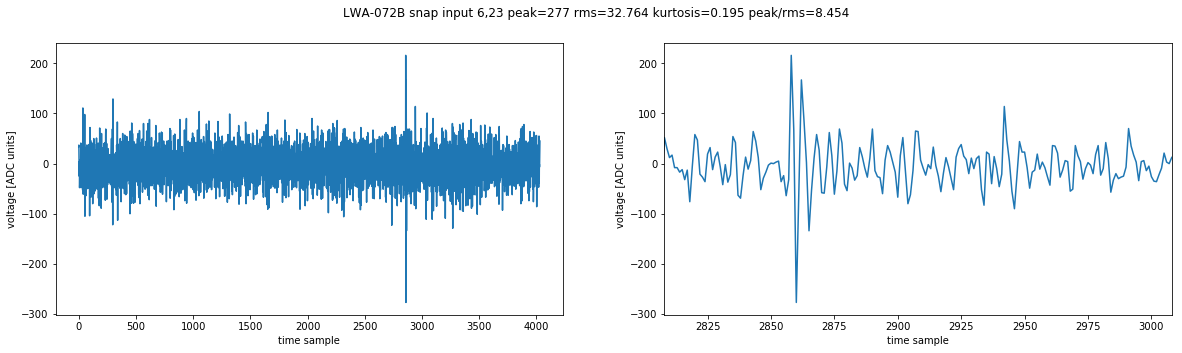

Amplitude timeseries with Filter 


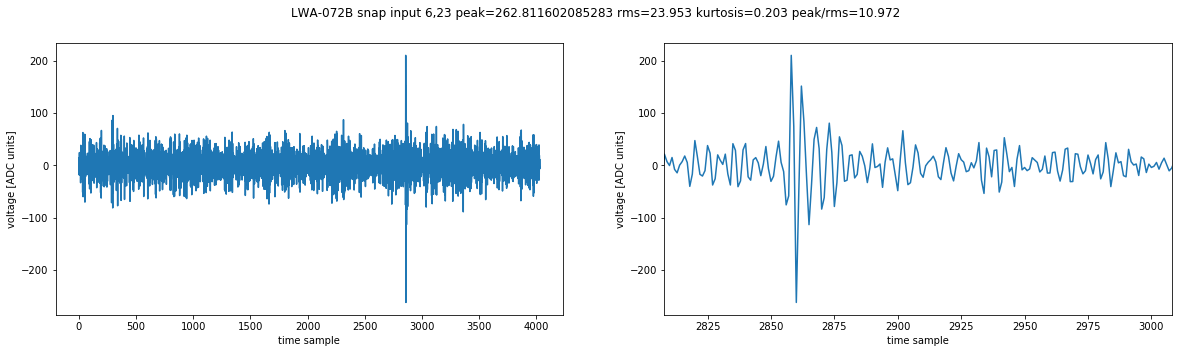

Amplitude timeseries with Filter no smoothing 


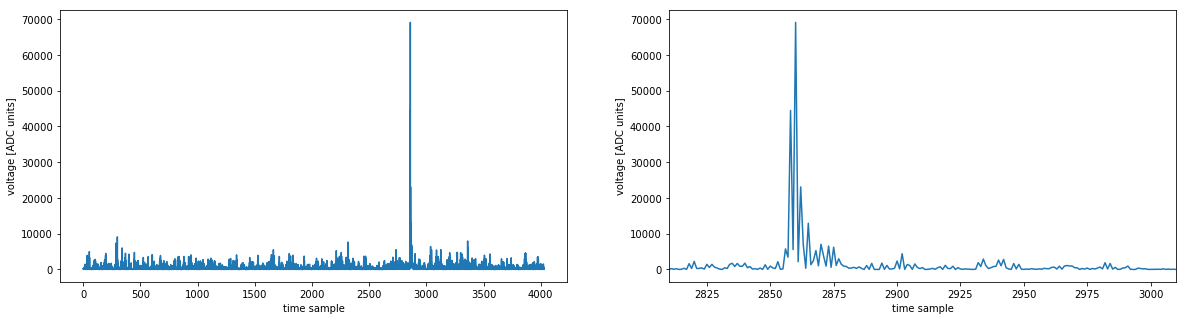

Amplitude timeseries with Filter and smoothing 


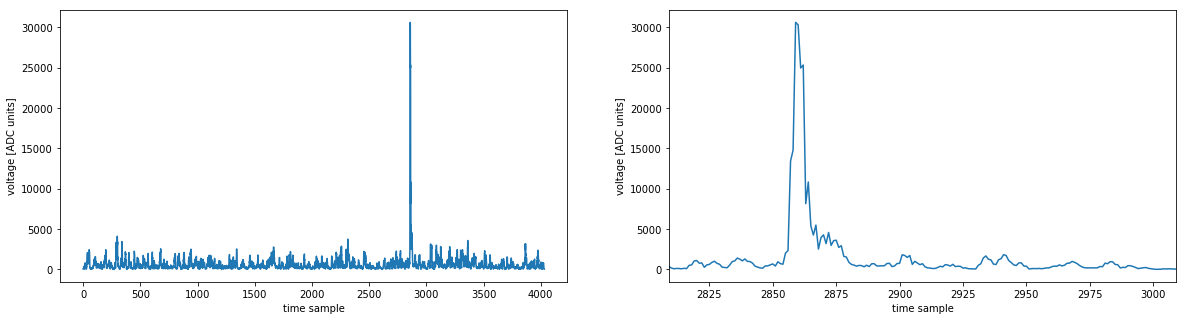

Amplitude timeseries, No filter


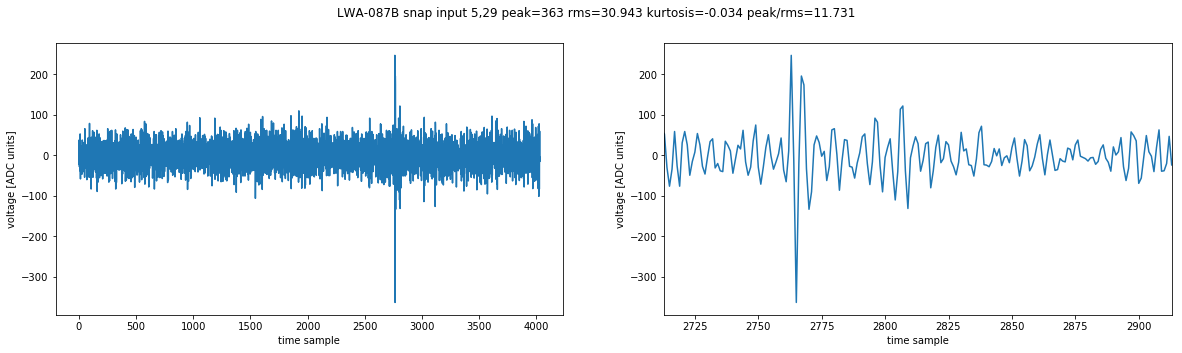

Amplitude timeseries with Filter 


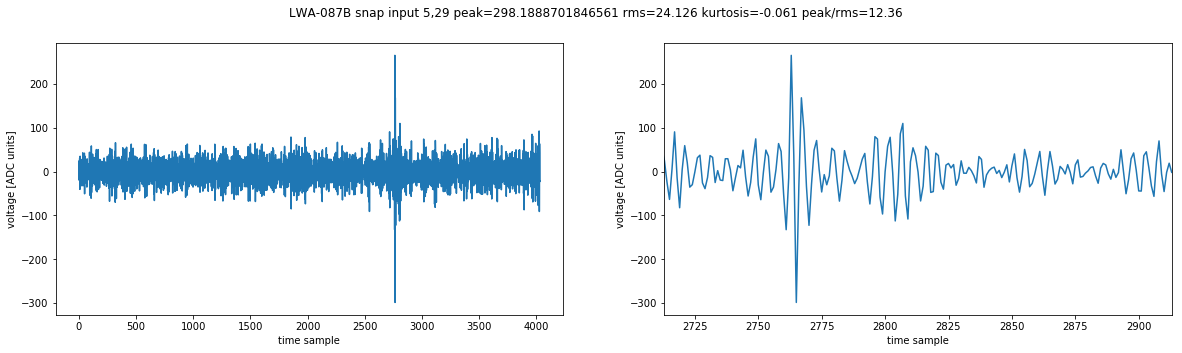

Amplitude timeseries with Filter no smoothing 


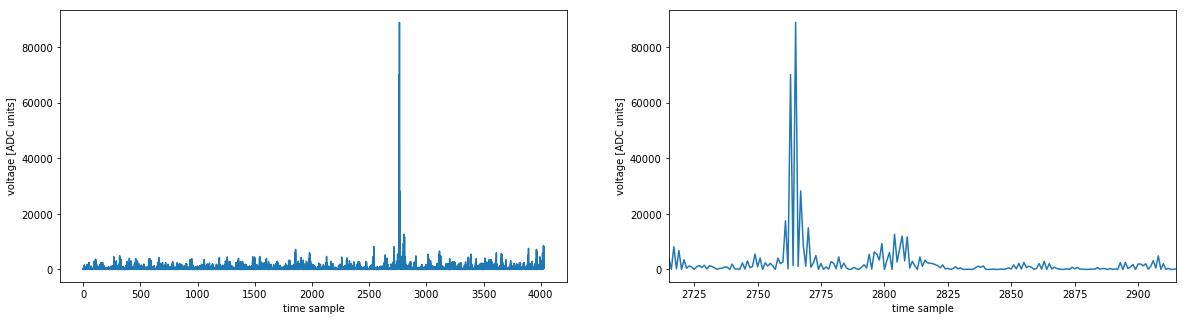

Amplitude timeseries with Filter and smoothing 


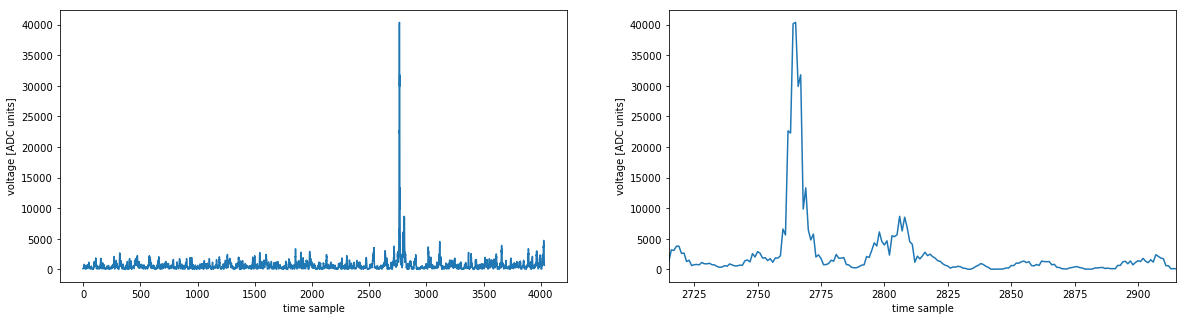

Amplitude timeseries, No filter


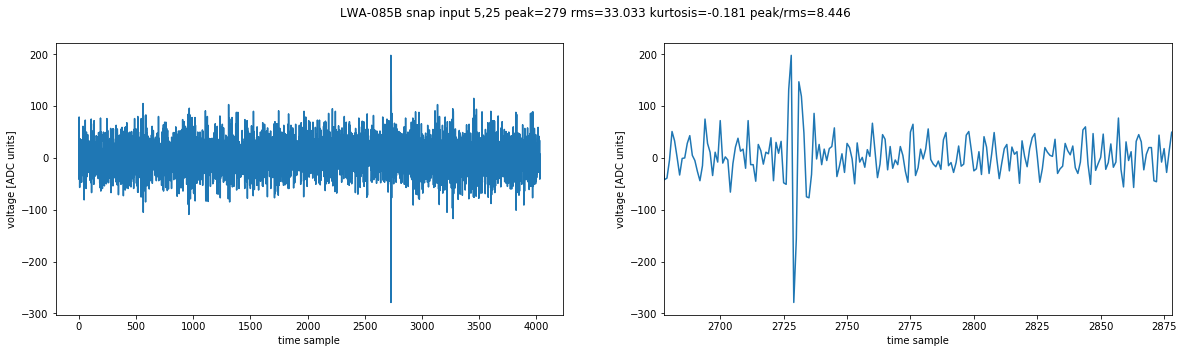

Amplitude timeseries with Filter 


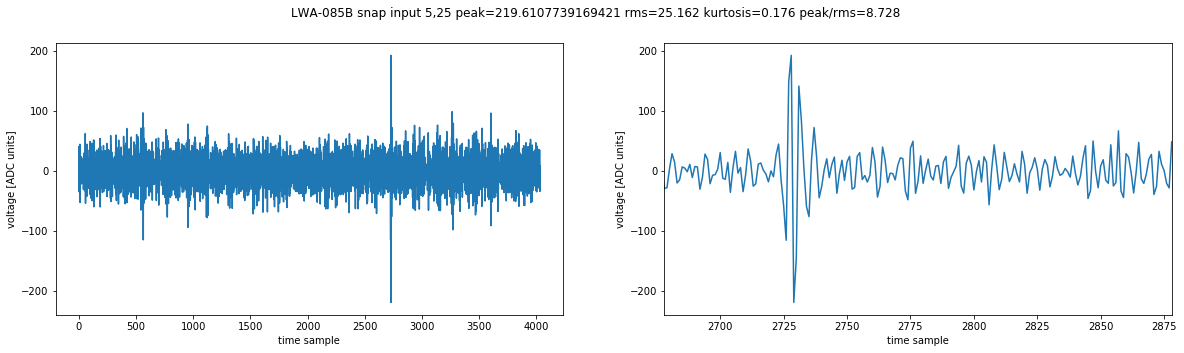

Amplitude timeseries with Filter no smoothing 


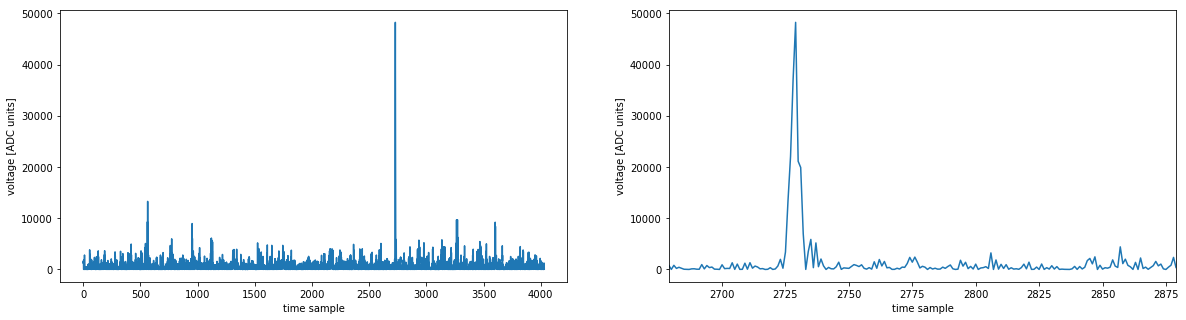

Amplitude timeseries with Filter and smoothing 


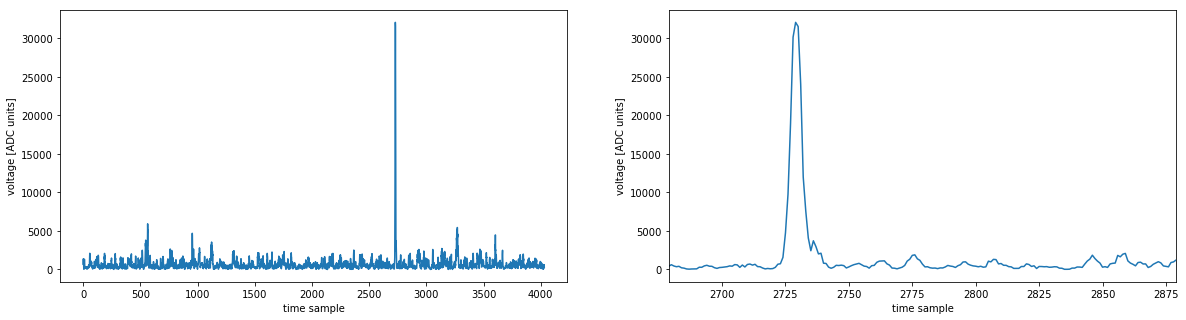

Amplitude timeseries, No filter


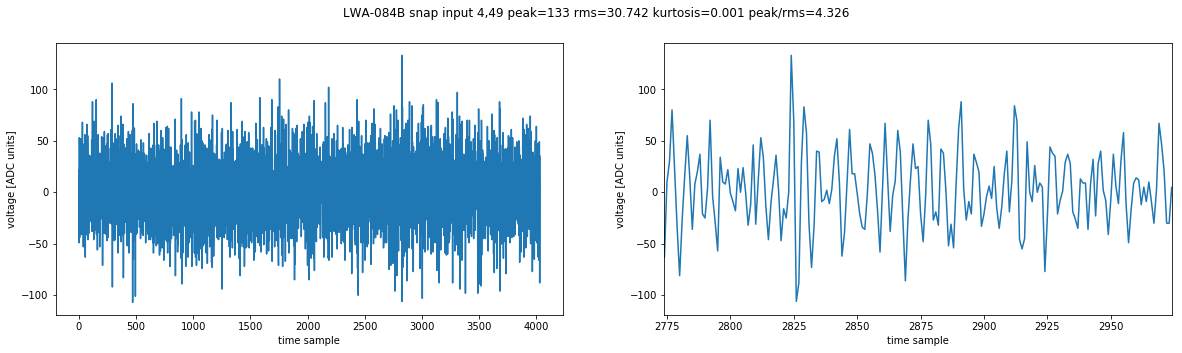

Amplitude timeseries with Filter 


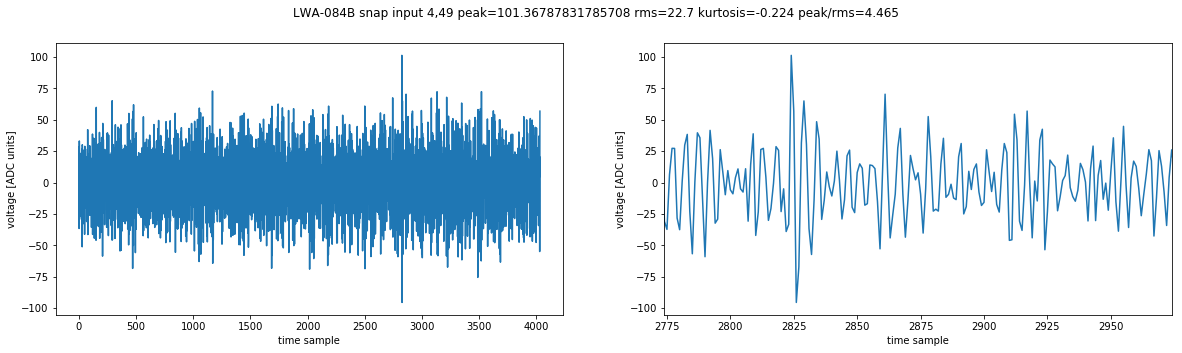

Amplitude timeseries with Filter no smoothing 


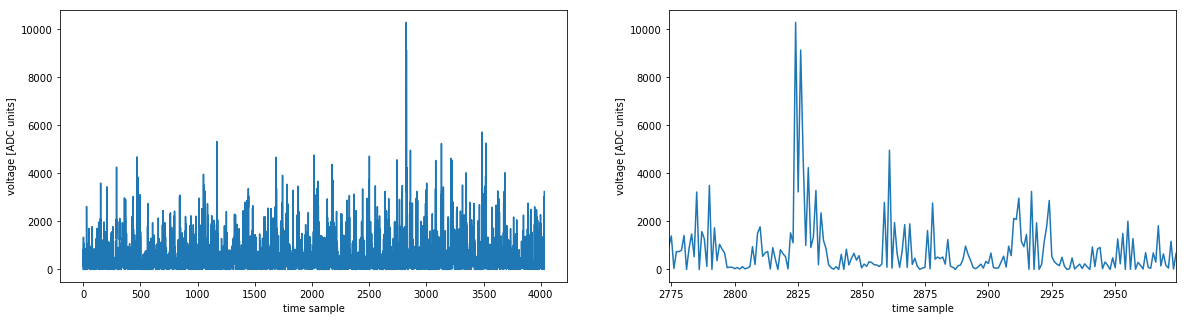

Amplitude timeseries with Filter and smoothing 


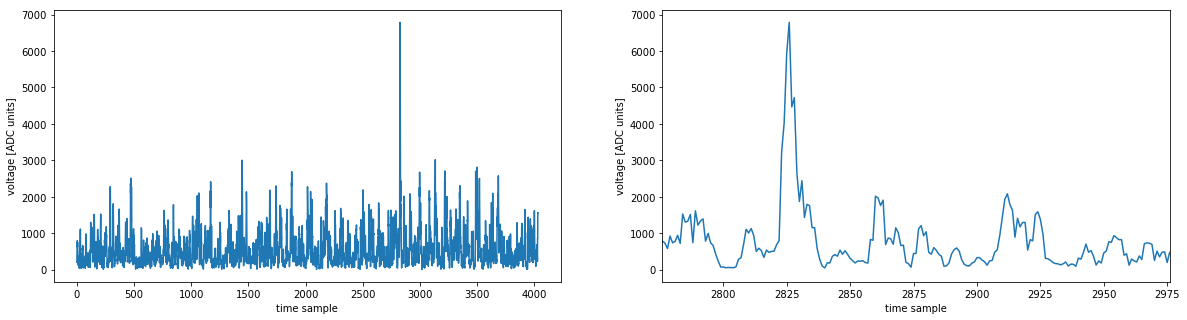

Amplitude timeseries, No filter


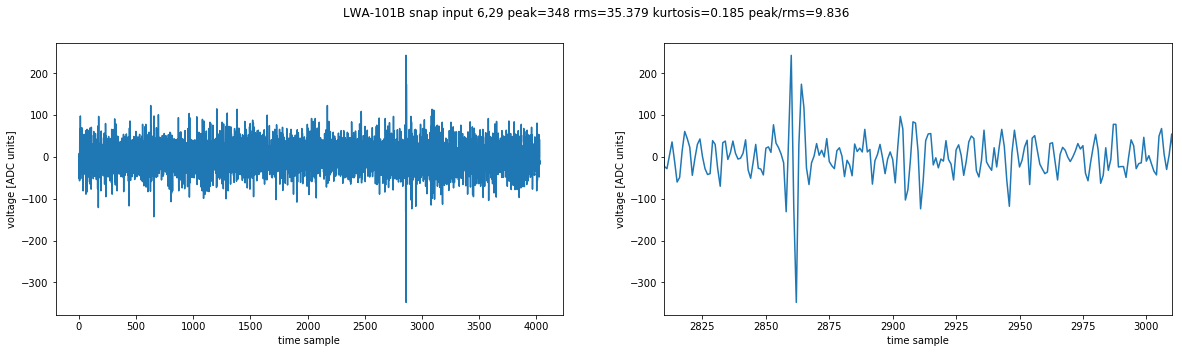

Amplitude timeseries with Filter 


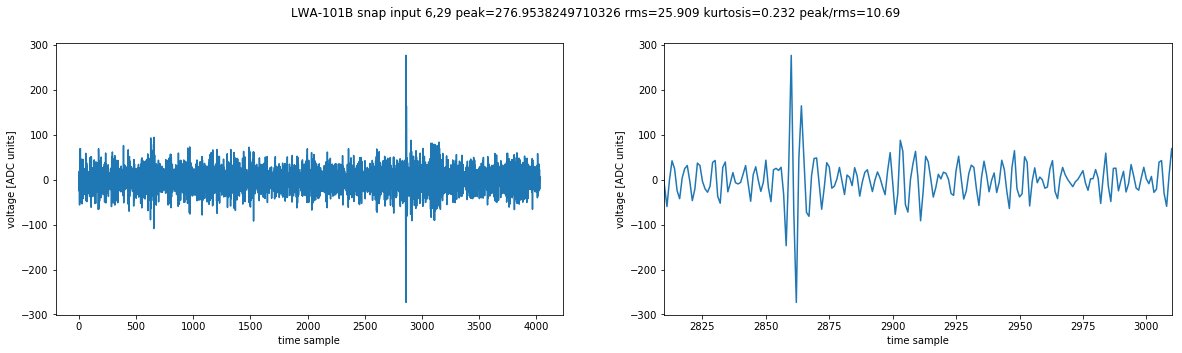

Amplitude timeseries with Filter no smoothing 


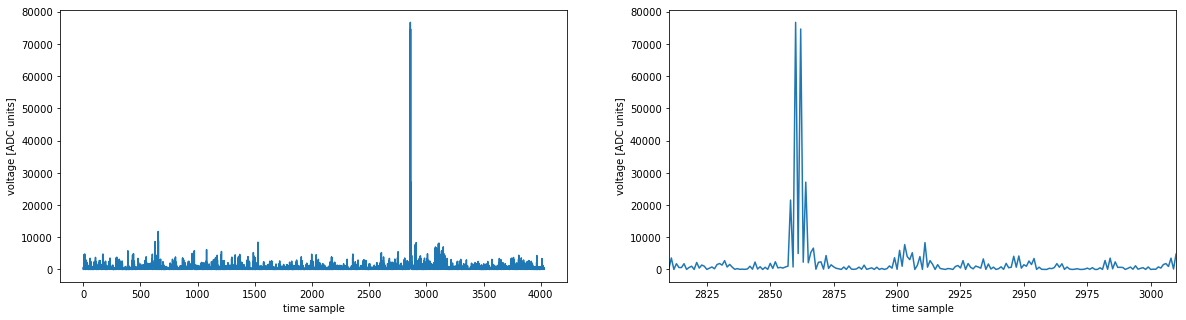

Amplitude timeseries with Filter and smoothing 


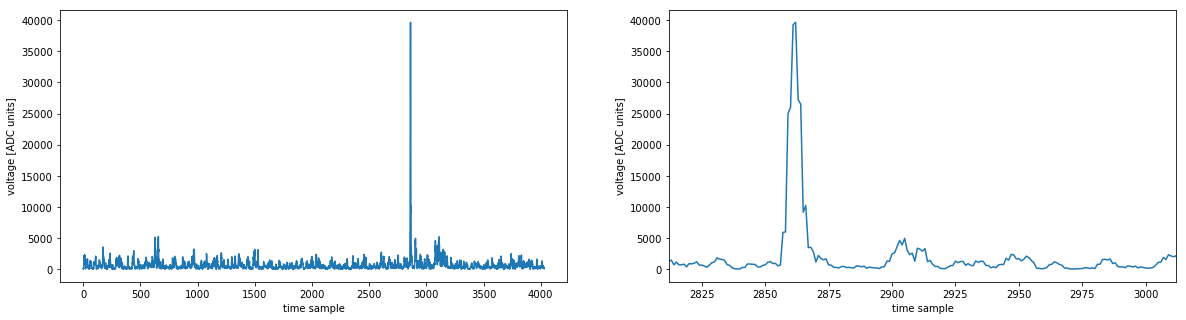

In [111]:
interesting_antennas=['LWA-107B','LWA-072B','LWA-087B','LWA-085B','LWA-084B','LWA-101B']
for A in interesting_antennas:
    print('Amplitude timeseries, No filter')
    plot_timeseries(event_records,A,zoom='peak',Filter='None')
    plt.show()
    print('Amplitude timeseries with Filter ')
    plot_timeseries(event_records,A,zoom='peak',Filter=h)
    plt.show()
    print('Amplitude timeseries with Filter no smoothing ')
    plot_power_timeseries(event_records,A,zoom='peak',Filter1=h,Filter2='None')
    plt.show()
    print('Amplitude timeseries with Filter and smoothing ')
    plot_power_timeseries(event_records,A,zoom='peak',Filter1=h,Filter2=(1/4)*np.ones(4))
    plt.show()


Amplitude timeseries, No filter


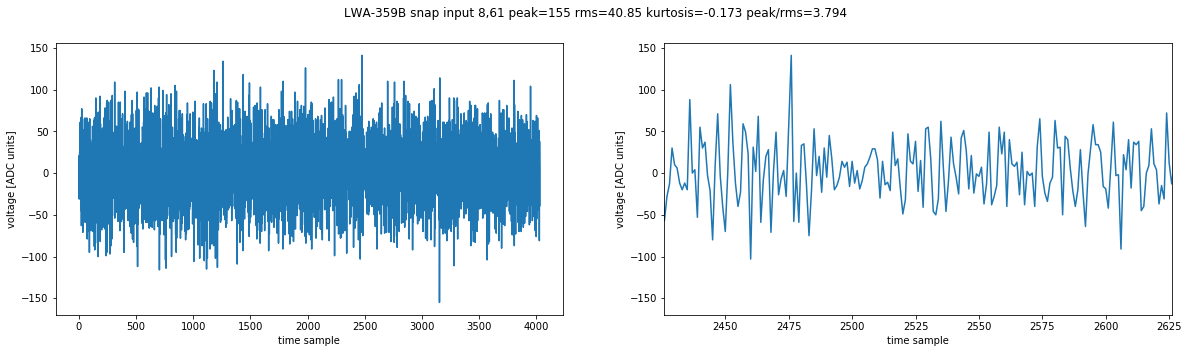

Amplitude timeseries with Filter 


/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':


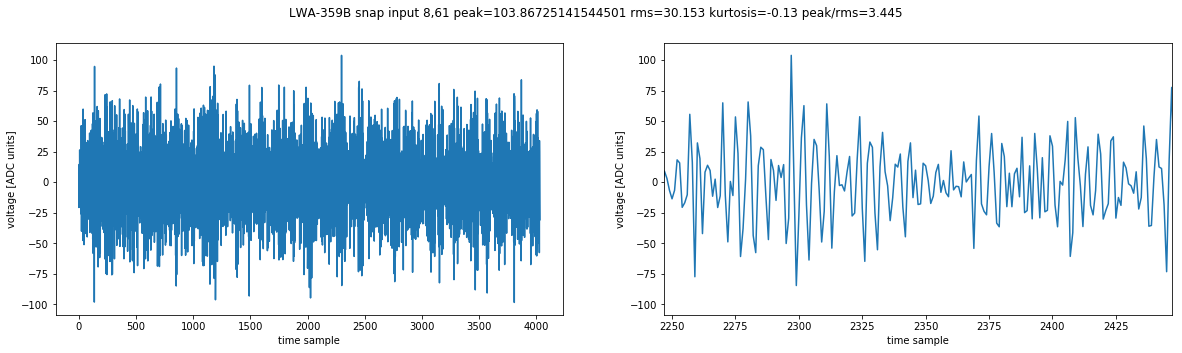

Amplitude timeseries with Filter no smoothing 


/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


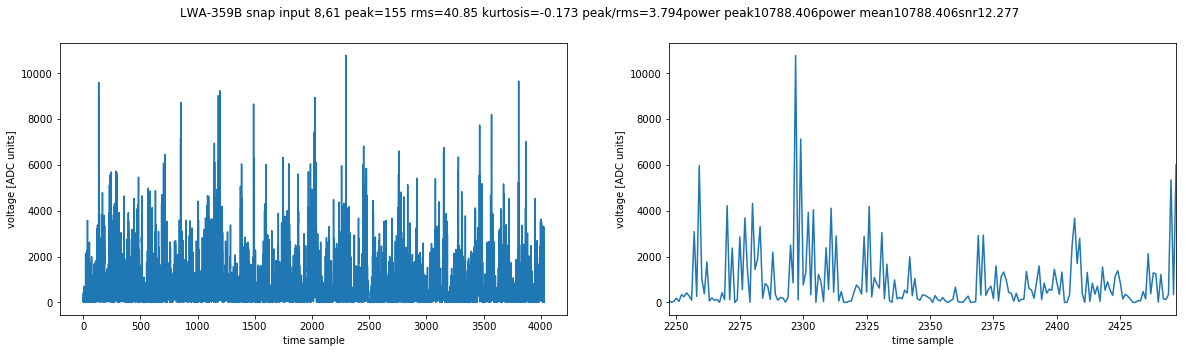

Amplitude timeseries with Filter and smoothing 


/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


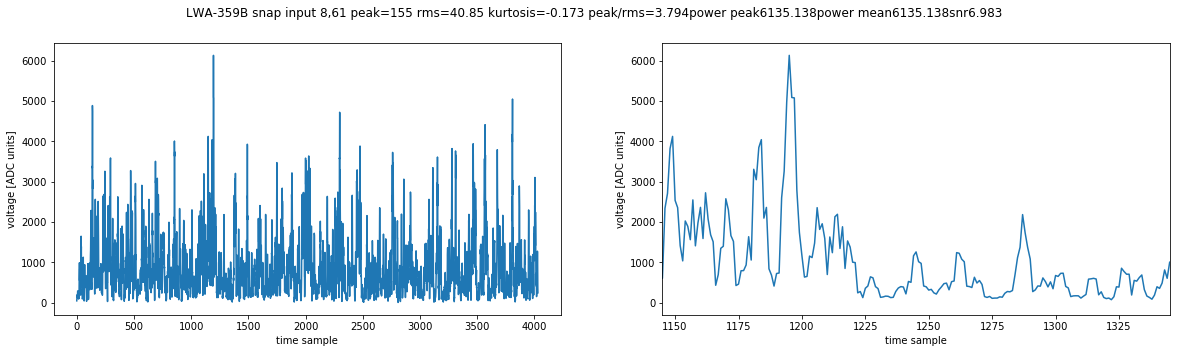

Amplitude timeseries, No filter


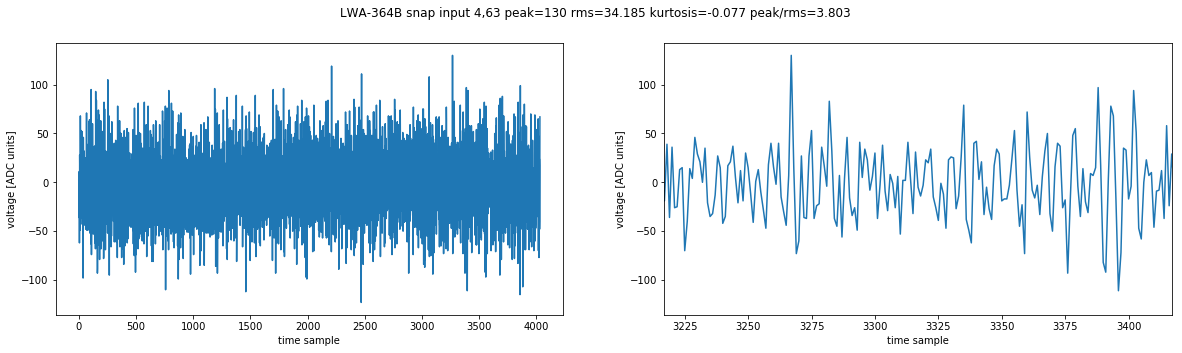

Amplitude timeseries with Filter 


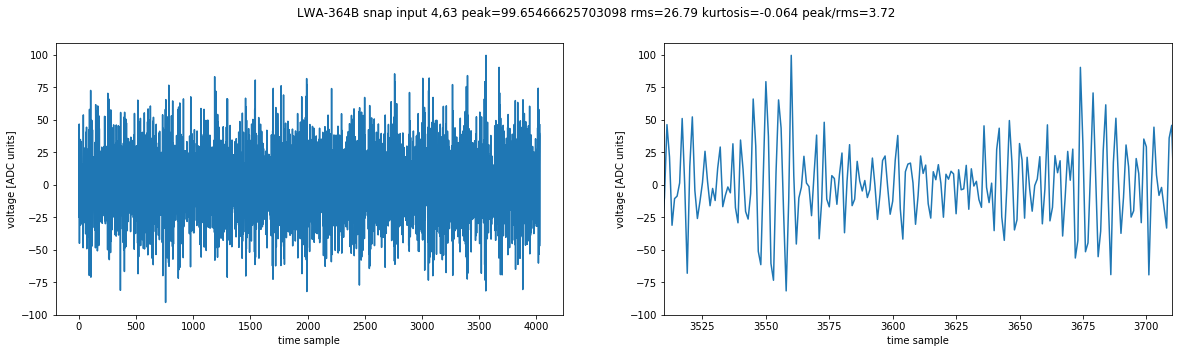

Amplitude timeseries with Filter no smoothing 


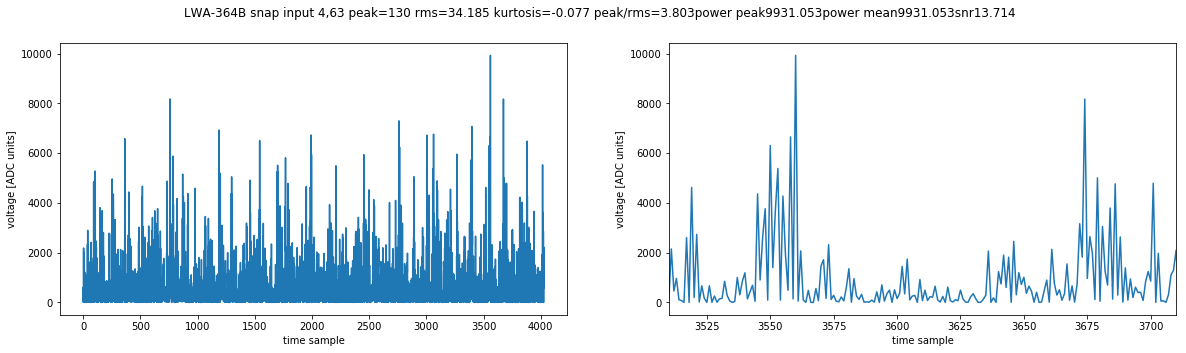

Amplitude timeseries with Filter and smoothing 


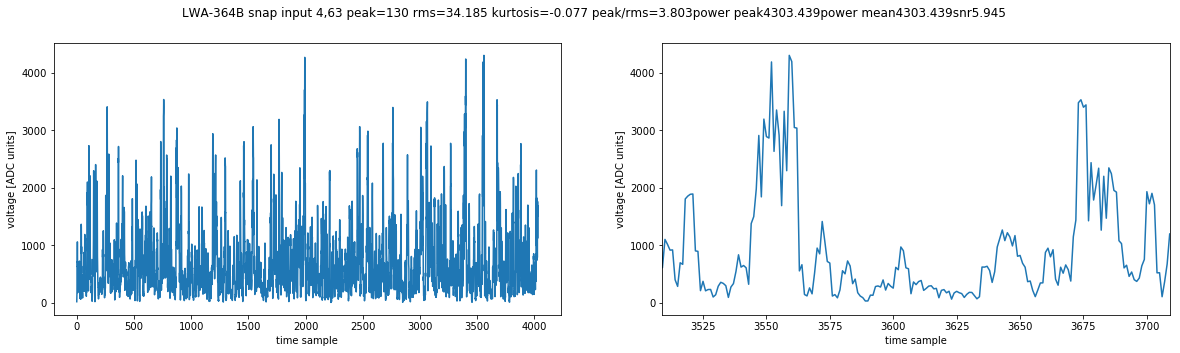

Amplitude timeseries, No filter


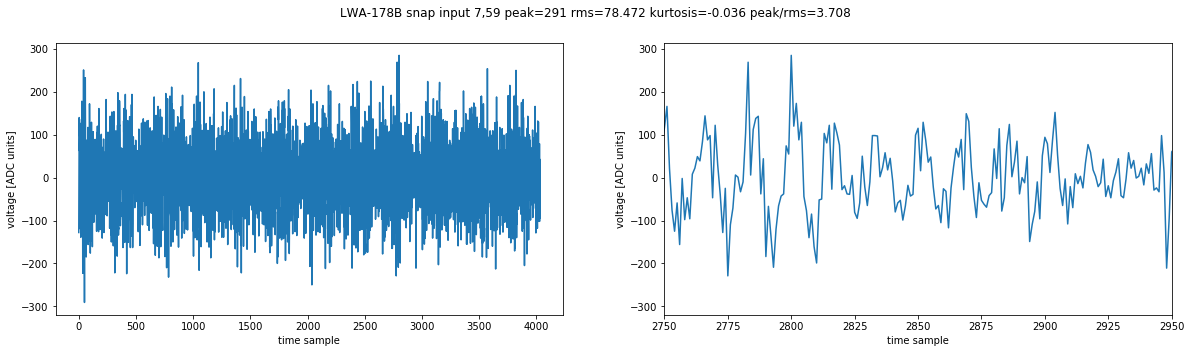

Amplitude timeseries with Filter 


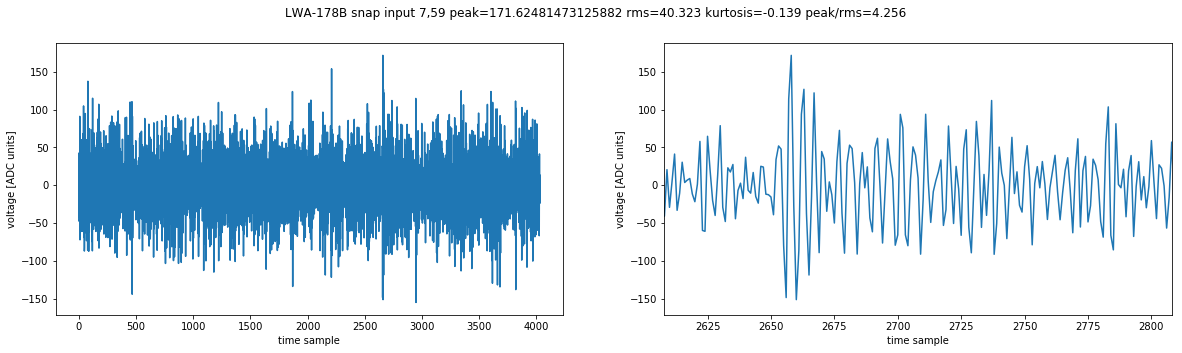

Amplitude timeseries with Filter no smoothing 


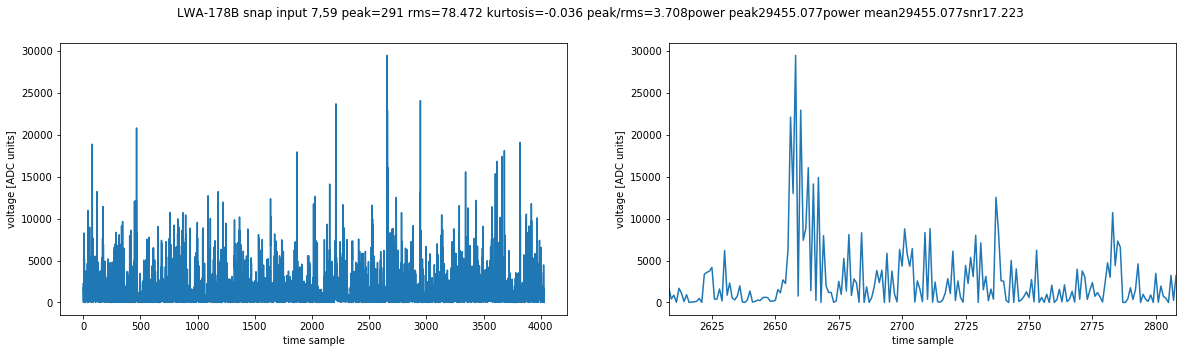

Amplitude timeseries with Filter and smoothing 


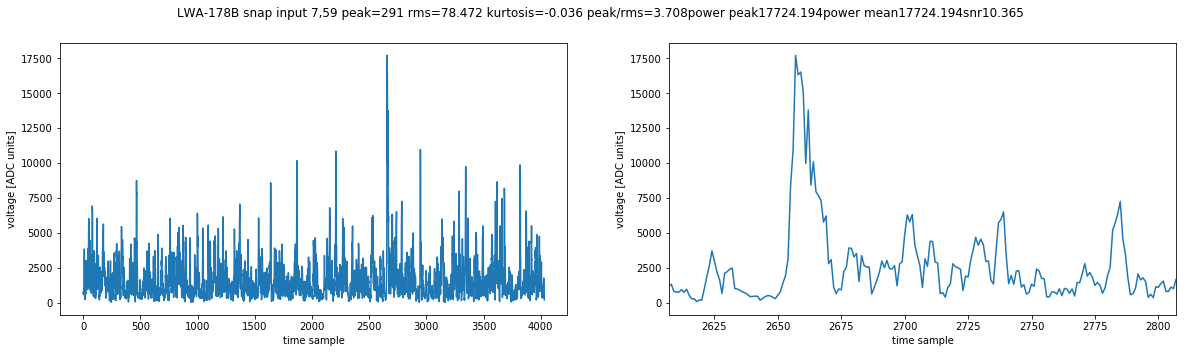

In [113]:
interesting_antennas=['LWA-359B','LWA-364B','LWA-178B']
for A in interesting_antennas:
    print('Amplitude timeseries, No filter')
    plot_timeseries(event_records,A,zoom='peak',Filter='None')
    plt.show()
    print('Amplitude timeseries with Filter ')
    plot_timeseries(event_records,A,zoom='peak',Filter=h)
    plt.show()
    print('Amplitude timeseries with Filter no smoothing ')
    plot_power_timeseries(event_records,A,zoom='peak',Filter1=h,Filter2='None')
    plt.show()
    print('Amplitude timeseries with Filter and smoothing ')
    plot_power_timeseries(event_records,A,zoom='peak',Filter1=h,Filter2=(1/4)*np.ones(4))
    plt.show()


## A different event

/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':
/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:218: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


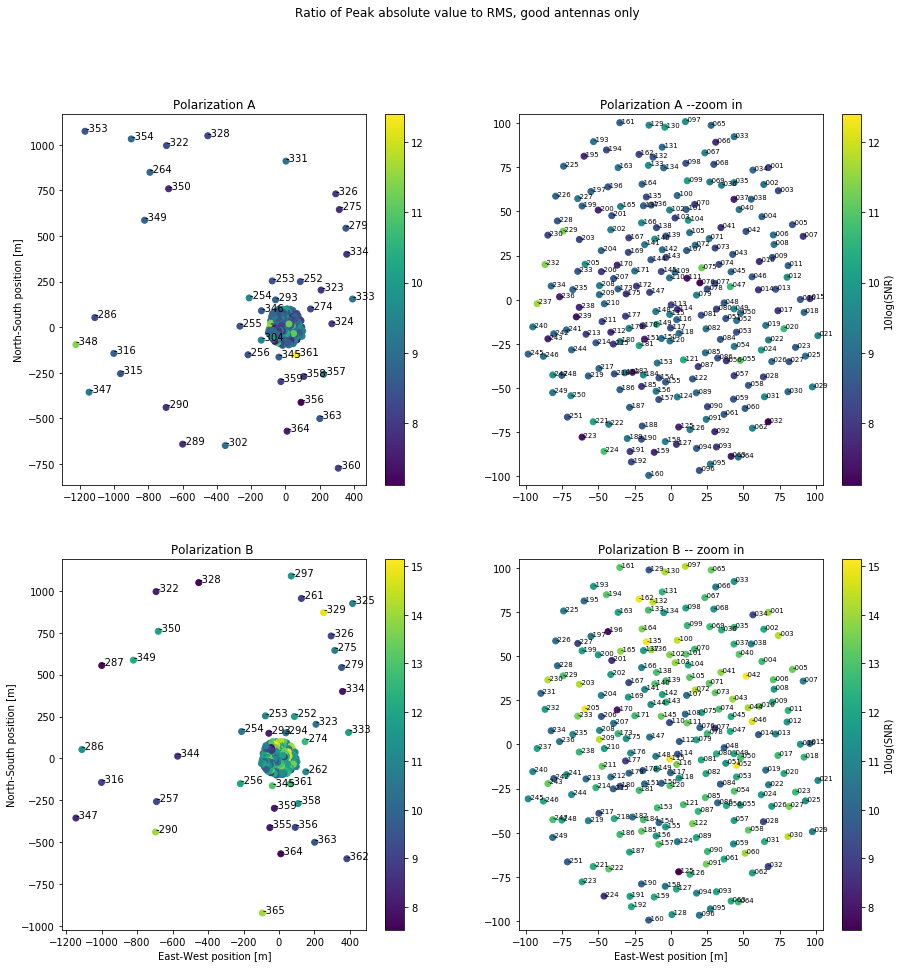

In [122]:

#load the desired event


datafname ='overnight1683181342.864461.dat' 
i=492341

event_records=parsefile(datadir+datafname,start_ind=i,end_ind=704 )

plot_event_smoothed_power_snr(event_records,arraymapdictionaries,minimum_ok_rms=15,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=True,Filter=h)